In [666]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn 
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier

#imblearn to balance training data
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from collections import Counter

# XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgb.set_config(verbosity=0) # to supress warnings

# Show pipelines as interactive diagram
from sklearn import set_config; set_config(display='diagram')

In [2]:
# Set random seed for reproducibility reasons
np.random.seed(42)

# Create clean dataframe


## Load dataset

In [3]:
df = pd.read_csv("../../data-cleaned/compas-scores-two-years-clean.csv")

## Filter dataset

ProPublicas reasoning for filter `raw_data`:
>However not all of the rows are useable for the first round of analysis.
>There are a number of reasons remove rows because of missing data:
>* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
>* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
>* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
>* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [4]:
df = df[
        (df["days_b_screening_arrest"]<=30) 
        & (df["days_b_screening_arrest"]>=-30) 
        & (df["is_recid"]!=-1) 
        & (df["c_charge_degree"]!="O") 
      ].dropna(subset=['score_text'])

- Since most of the columns in the dataset describe charges after the initial COMPAS screening. Therefore these columns can not be used as predictors. 
- Furthermore we compared the original questionaire for the COMPAS scoring with the data of our datasets: 
- From the X sections in the original questionaire we only have data about demographics, criminal history and current charges from the defendant. 

In [5]:
# Select columns of interest and store as new df
columns = ["id", "age", "age_cat", "sex", "race",  #demographics
           "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
           "c_charge_degree", "c_charge_desc", #current charges
           "score_text", "decile_score", #compas results for current charges -> target for regression (COMPAS scores for general recidivism)
           "r_charge_degree", "r_charge_desc", #commited crimes (general) within 2 years after COMPAS scoring (no feature for final model, but relevant fro feature engineering)
           "two_year_recid"] #target for classification 
df_clean = df[columns]

In [6]:
# Drop duplicates (there are none, but for completness we introduce the step anyhow)
df_clean = df_clean.drop_duplicates()

## Check missing values and dtypes

In [7]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5304 entries, 0 to 6215
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               5304 non-null   int64 
 1   age              5304 non-null   int64 
 2   age_cat          5304 non-null   object
 3   sex              5304 non-null   object
 4   race             5304 non-null   object
 5   juv_fel_count    5304 non-null   int64 
 6   juv_misd_count   5304 non-null   int64 
 7   juv_other_count  5304 non-null   int64 
 8   priors_count     5304 non-null   int64 
 9   c_charge_degree  5304 non-null   object
 10  c_charge_desc    5299 non-null   object
 11  score_text       5304 non-null   object
 12  decile_score     5304 non-null   int64 
 13  r_charge_degree  2122 non-null   object
 14  r_charge_desc    2095 non-null   object
 15  two_year_recid   5304 non-null   int64 
dtypes: int64(8), object(8)
memory usage: 704.4+ KB


- Some columns contain null values, but out of these only `c_charge_desc`will be relevant for modeling, since the other columns contain data which was generated after the COMPAS screening, an thus can not be used 
- The imputing of missing values will be performed during the preprocessing 

## Check outliers

In [8]:
df_clean[["age", 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']].describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,5304.000000,5304.000000,5304.000000,5304.000000,5304.000000
mean,34.953431,0.052036,0.088047,0.101433,2.993590
std,11.817771,0.382938,0.511951,0.448231,4.458153
min,19.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,0.000000,1.000000
75%,43.000000,0.000000,0.000000,0.000000,4.000000
max,96.000000,10.000000,13.000000,9.000000,37.000000


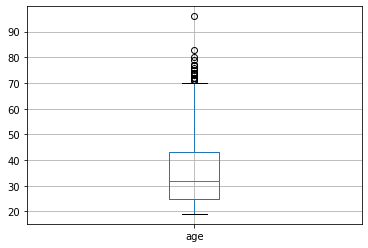

In [9]:
df_clean[["age"]].boxplot();

In [10]:
print(f"There are {df_clean[df_clean['age']>70].shape[0]} defendants who are older than 70 years")
print("Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed")

There are 22 defendants who are older than 70 years
Even though these cases are marked as outliers, they seem to be valid cases and thus should not be removed


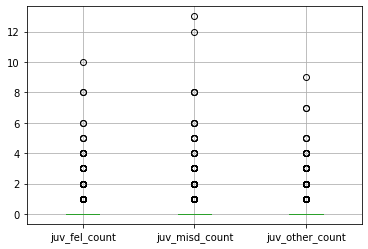

In [11]:
df_clean[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].boxplot();

In [12]:
print(f"Defendants with >0 juv_fel_count: {df_clean[df_clean['juv_fel_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_fel_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_misd_count: {df_clean[df_clean['juv_misd_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_misd_count']>0].shape[0]/df_clean.shape[0],2)}%")
print(f"Defendants with >0 juv_other_count: {df_clean[df_clean['juv_other_count']>0].shape[0]}, {np.round(df_clean[df_clean['juv_other_count']>0].shape[0]/df_clean.shape[0],2)}%")

Defendants with >0 juv_fel_count: 164, 0.03%
Defendants with >0 juv_misd_count: 277, 0.05%
Defendants with >0 juv_other_count: 368, 0.07%


- The vast majority of defendants in this dataset has no criminal juvenile records. 
- Even though the numbers are relatively small, there is no indication that there was an error in creating the dataset
- These repeated juvenile offenders seem to be rare, but valid "outliers" and thus should not be removed!

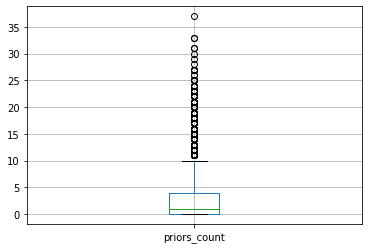

In [13]:
df_clean[['priors_count']].boxplot();

In [14]:
print(f"Defendants with >10 priors: {df_clean[df_clean['priors_count']>10].shape[0]}, \
{np.round(df_clean[df_clean['priors_count']>10].shape[0]/df_clean.shape[0],2)}%")

Defendants with >10 priors: 365, 0.07%


There are 365 defendants with more than 10 priors. Nevertheless these repeated offenders seem to be rare, but valid "outliers" and thus should not be removed!

## Scoring

### Choose scoring metrics

**Classification**

In [15]:
#Checking class distribution target y
df_clean.two_year_recid.value_counts()

0    3363
1    1941
Name: two_year_recid, dtype: int64

In [16]:
df_clean.two_year_recid.value_counts(normalize=True)

0    0.63405
1    0.36595
Name: two_year_recid, dtype: float64

We have an uneven class distribution in our target

We will try to predict whether a person will re-offend in the following two years or not. 
- The cost of false positives (predict that someone will re-offend, but did not) is high for the defendant, since the person will probably stay in custody until trial. 
- The cost of false negatives (predict that someone will not re-offend, but did) is high for society since most crimes include a victim



In [159]:
clf_scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss']

---
**Regression**

### Create functions for storing results from cross validation and GridSearch

- We will store the cross validated and GridSearch results as well as the model name
- This will be used in the end to compare the different estimators and select the best model

In [164]:
# List for cross validated models (no GridSearch)
cv_results_list=[]
cv_models_list=[]

# List for cross validated models using GridSearch
grid_results_list=[]
grid_models_list=[]

# Dictonary of trained models
dict_models = {}

In [573]:
def save_cv_results(cv_results_list, model_name_list):
    '''Store cv results for all splits and metrics as a list of df'''
    cv_results_df=[]
    
    for i, cv_results in enumerate(cv_results_list):
    
        cv_results = pd.DataFrame(cv_results)

        # Subsetting cv_results (exclude time metrics)
        time_metrics = ['fit_time','score_time'] # fit time metrics
        cv_results_nofit = cv_results.loc[:,~cv_results.columns.isin(time_metrics)].copy()

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in cv_results_nofit.columns:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            cv_results_nofit["test_neg_log_loss"] = cv_results_nofit["test_neg_log_loss"].abs()
            cv_results_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
        
        cv_results_nofit["model"]=model_name_list[i]
        cv_results_df.append(cv_results_nofit)
        
    return cv_results_df
    # Create df for plot
    #final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

In [172]:
def save_grid_cv_results(grid_model_list, model_name_grid_list, scorings):
    '''Store cv results for each split for each metric of GridSearch of best model as list of df'''
    grid_cv_results_df=[]
    
    for i, grid_model in enumerate(grid_model_list):

        # get index of best model 
        indx = grid_model.cv_results_["params"].index(grid_model.best_params_)

        # Filter grid search cv results for best model
        cv_results_grid = {k:v[indx] for (k,v) in grid_model.cv_results_.items() if k.startswith('split')}

        #scoring metrics
        col_dict = ["test_"+x for x in scorings]

        # Creat dict for plotting with results for each split for each metric of GridSearch for best model
        final_dict = {}
        for col in col_dict:
            for (k,v) in cv_results_grid.items():
                if k.endswith(col):
                    final_dict.setdefault(col, []).append(v)

        df_final = pd.DataFrame(final_dict)
        df_final["model"]=model_name_grid_list[i]

        #Rename negative log loss and change values to positives (for plotting reasons)
        if "test_neg_log_loss" in col_dict:
            # Change neg_log_loss to positive number (for plotting) and rename columns
            df_final["test_neg_log_loss"] = df_final["test_neg_log_loss"].abs()
            df_final.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
    
        grid_cv_results_df.append(df_final)
        
    
    return grid_cv_results_df

In [361]:
## Function for scoring all models on test set and print results (confusion matrix and boxplot)

# Feature Engineering: Create feature `c_charge_degree_detailed`

- The current charges of the ProPublica dataset are categorized as felonies or misdemeanors `c_charge_degreee``
- The `c_charge_desc` contains the description of the crime (e.g. murder, Grand theft ...)
- In Florida each crime is based on the severness categorised into different level/ classes of misdemeanors or felonies

In [17]:
# There are 358 unique charges in the dataset in total (wo NaN)
print("Unique charges in the dataset:", len(df_clean.c_charge_desc.unique()))

# There are 265 unqiue charges for felonies (23 of them also exist in misdemeanor) (wo NaN)
print("Unique charges for felonies:", len(df_clean[df_clean["c_charge_degree"]=="F"]
                                          [["c_charge_degree", "c_charge_desc"]]
                                          .c_charge_desc.unique()))

# There are 125 unqiue charges for misdemeanors  (wo NaN)
print("Unique charges for misdemeanors:", len(df_clean[df_clean["c_charge_degree"]=="M"]
                                              [["c_charge_degree", "c_charge_desc"]]
                                              .c_charge_desc.unique()))

Unique charges in the dataset: 359
Unique charges for felonies: 266
Unique charges for misdemeanors: 126


- In order to reduce the variaty of charges we created a new feature to cluster each crime into the correct level
- The original dataset already contains the more detailed degree of crimes, but only for the recidivist crimes
- We first used these crimes and map them against the current charges 

In [18]:
# check unique values/ classes of charges 
df_clean.r_charge_degree.unique()

array([nan, '(F3)', '(M1)', '(F2)', '(M2)', '(MO3)', '(F1)', '(F6)',
       '(F7)', '(CO3)', '(F5)'], dtype=object)

In [19]:
# Create lookup table for c_charge_degree_detailed based on c_charge_desc
lookup_c_charge_degree = pd.merge(
    df_clean[["c_charge_desc"]], 
    df_clean[
        (df_clean["r_charge_degree"]!='(MO3)') & #filter out classes of felonies and misdemeanors who do not exist
        (df_clean["r_charge_degree"]!='(F6)') &
        (df_clean["r_charge_degree"]!='(F7)') &
        (df_clean["r_charge_degree"]!='(CO3)') & 
        (df_clean["r_charge_degree"]!='(F5)') &
        (df_clean["r_charge_degree"]!=np.nan)
        ][["r_charge_degree", "r_charge_desc"]], 
    left_on="c_charge_desc", 
    right_on="r_charge_desc")

In [20]:
#drop duplicated c_charge_desc so we end up with unique charges and degrees
lookup_c_charge_degree = lookup_c_charge_degree[["c_charge_desc", "r_charge_degree"]].drop_duplicates()
lookup_c_charge_degree.columns = ["c_charge_desc", "c_charge_degree_detailed"]

#reset index 
lookup_c_charge_degree = lookup_c_charge_degree.reset_index(drop=True)
lookup_c_charge_degree

,c_charge_desc,c_charge_degree_detailed
0,Felony Battery w/Prior Convict,(F3)
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
...,...,...
169,Deliver Cannabis 1000FTSch,(F2)
170,Sex Batt Faml/Cust Vict 12-17Y,(F1)
171,Possession Of Clonazepam,(F3)
172,Deliver Cocaine 1000FT School,(F1)


In [21]:
#Find charges which do have multiple charge_degrees
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed
1,Possession of Cocaine,(F3)
2,Possession of Cocaine,(M1)
3,Battery,(M1)
4,Battery,(M2)
12,Susp Drivers Lic 1st Offense,(M2)
13,Susp Drivers Lic 1st Offense,(M1)
29,False Ownership Info/Pawn Item,(F3)
30,False Ownership Info/Pawn Item,(F2)
36,Petit Theft,(M2)
37,Petit Theft,(M1)


In [22]:
#Decide for one degree for each duplicate -> we keep the harder class degrees (based on online research)
rows_to_drop = [2, 4, 12, 13, 29, 36, 43, 53, 65, 88]

#drop rows based on index 
lookup_c_charge_degree = lookup_c_charge_degree.drop(index=rows_to_drop)

In [23]:
#check that there are no more duplicates 
lookup_c_charge_degree.groupby("c_charge_desc").filter(lambda x: len(x) > 1)

,c_charge_desc,c_charge_degree_detailed


In [24]:
#set index to c_charge_desc and drop row with c_charge_desc = NaN
lookup_c_charge_degree.set_index("c_charge_desc", inplace=True)
lookup_c_charge_degree = lookup_c_charge_degree[lookup_c_charge_degree.index.notnull()]

#Remove parenthesis from the labels 
lookup_c_charge_degree["c_charge_degree_detailed"] = lookup_c_charge_degree.c_charge_degree_detailed.str.strip("( )")

In [25]:
#Use lookup table to label charges based on description
charges_to_label = df_clean.merge(lookup_c_charge_degree, how="left", left_on="c_charge_desc", right_index=True)

In [26]:
charges_to_label[charges_to_label["c_charge_degree_detailed"].notna()].shape

(4099, 17)

- 4099 of the 5304 cases could be labeled automatically based on the r_charge_degree 
- The remaining chases/charges need to be labeled manually

## Create list for charges which could not be matched automatically and need to be labeled manually

In [27]:
#Filter for rows which could not be labeled by the current lookup table (because they did not exist in r_charge_desc)
charges_to_label = charges_to_label[charges_to_label["c_charge_degree_detailed"].isnull()]

In [28]:
# Create list of unique charges which could not be labeled. These charges need to be labeled manually (online research)
charges_to_label_list = charges_to_label.groupby("c_charge_desc")[["id"]].count().sort_values(by="id", ascending=False)
charges_to_label_list["c_charge_degree_detailed"]=""
charges_to_label_list.columns = ['count', 'c_charge_degree_detailed']

charges_to_label_list

,count,c_charge_degree_detailed
c_charge_desc,,
arrest case no charge,684,
Felony Driving While Lic Suspd,73,
Susp Drivers Lic 1st Offense,45,
Aggravated Assault w/Firearm,20,
Poss Contr Subst W/o Prescript,15,
...,...,...
False Name By Person Arrest,1,
Falsely Impersonating Officer,1,
Grand Theft of a Fire Extinquisher,1,


There are 684 cases where the defendant wasn't pressed with charges. These cases will be encoded as `0` (less severe than M2 misdemeanors)

In [29]:
# Export to .csv file so the charges can be labeled manually (only has to be executed once)
# charges_to_label_list.to_csv("charges_to_label.csv")

## Import manually labeld .csv file and combine with `lookup_c_charge_degree` to create master lookup table

In [30]:
# import manually labeled data
labeled_charges_man = pd.read_csv("charges_labeled_man.csv", index_col=0).set_index("c_charge_desc")[["c_charge_degree_detailed"]]

In [31]:
#Create master lookup table by combining manually labeled data with automatically labeled data
lookup_c_charge_degree_master = pd.concat([lookup_c_charge_degree, labeled_charges_man], axis=0)

In [32]:
# Save master lookup table as .csv so it can be imported directly (only has to be executed once)
#lookup_c_charge_degree_master.to_csv("labeled_charges_master.csv")

## Map charge degree to all cases and store in new feature column `c_charge_degree_detailed`

In [33]:
# Load master lookup table
labeled_charges_master = pd.read_csv("labeled_charges_master.csv", index_col="c_charge_desc")

In [34]:
# Map charge degree to all cases and store in new column "c_charge_degree_detailed"
df_clean = df_clean.merge(labeled_charges_master, how="left", left_on="c_charge_desc", right_index=True)
df_clean.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='c_charge_degree_detailed', ylabel='count'>

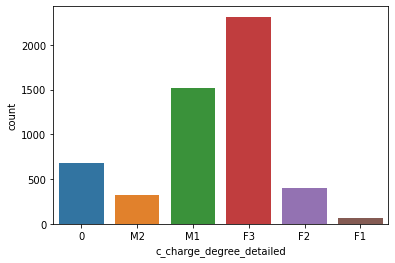

In [35]:
sns.countplot(x="c_charge_degree_detailed", data=df_clean, order=["0","M2", "M1", "F3", "F2", "F1"])

- More than 50% of charges in our dataset were labeled as M1 or F3 
- 684 cases are encoded as 0 (arrest case no charge)

In [36]:
#Check NaN values (values which did not have a c_charge_desc in the original dataset)
df_clean[df_clean.c_charge_degree_detailed.isnull()]

,id,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,score_text,decile_score,r_charge_degree,r_charge_desc,two_year_recid,c_charge_degree_detailed
114,243,39,25 - 45,Male,Caucasian,1,0,0,1,M,NaN,Low,4,NaN,NaN,0,NaN
2191,4521,27,25 - 45,Female,Caucasian,0,0,0,0,F,NaN,Medium,5,NaN,NaN,0,NaN
4031,8299,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,4,NaN,NaN,0,NaN
4202,8679,27,25 - 45,Male,African-American,0,0,0,2,F,NaN,Low,3,NaN,NaN,0,NaN
5183,10737,69,Greater than 45,Female,Caucasian,0,0,0,5,F,NaN,Low,3,NaN,NaN,0,NaN


In [37]:
index_nan_cases = df_clean[df_clean.c_charge_degree_detailed.isnull()].index

- There are still 5 cases which did not have a description of the current charges. 
- These 5 cases need to be imputed
- This requires the encoding of all categorical features first

# Data preprocessing

## Select relevant features and perform train_test_split

### Create Dataframe without `race`

In [38]:
#Select features for Classification model of general recidivism
# Select age or age_cat, exclude/ include race
columns_clas = ["age", "age_cat", "sex", #"race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas = df_clean[columns_clas].copy()

X = df_clas.drop(columns="two_year_recid")
y = df_clas["two_year_recid"]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

### Create Dataframe with `race`

In [40]:
columns_clas_race = ["age", "age_cat", "sex", "race",  #demographics
               "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", #criminal history
               "c_charge_degree", "c_charge_degree_detailed", #current charges 
               "two_year_recid"] #truth

df_clas_race = df_clean[columns_clas_race].copy()

X_race = df_clas_race.drop(columns="two_year_recid")
y_race = df_clas_race["two_year_recid"]

In [41]:
X_train_race, X_test_race, y_train_race, y_test_race = train_test_split(X_race,y_race, test_size=0.3)

## Create preprocessing pipeline

- `preproc_numerical` to impute and scale features
- `preproc_ordinal` to ordinaly encode `
- `preproc_nominal` to one hot encode the other ones (only relevant when race would be a feature)

### Preprocessing pipeline without `race`as feature

In [218]:
feat_ordinal_dict = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    #"sex": ["Male","Female"],
    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"]
    }

feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

encoder_ordinal = OrdinalEncoder(
    categories=feat_ordinal_values_sorted,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    encoder_ordinal,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['Less than 25', '25 - 45',
                                             'Greater than 45'],
                                            ['M', 'F'],
                                            ['0', 'M2', 'M1', 'F3', 'F2',
                                             'F1']],
                                dtype=<class 'numpy.int64'>,
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('knnimputer', KNNImputer(missing_values=-1, n_neighbors=25)),
                ('minmaxscaler', MinMaxScaler())])

In [219]:
# Define numerical feature once-for-all
#from sklearn.compose import make_column_selector
#feat_numerical = make_column_selector(dtype_include='number')

feat_numerical = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
#feat_numerical = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)


preproc_numerical = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [220]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X_train.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [221]:
preproc = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal, feat_ordinal),
    (preproc_nominal, feat_nominal), 
    remainder="drop")

preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['sex'])])

In [222]:
#Test preproc pipeline
preproc.fit(X_train)

column_nam = feat_numerical + feat_ordinal +list(preproc.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal))

test = pd.DataFrame(preproc.transform(X_train), columns=column_nam)

test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,sex_Male
0,0.207792,0.0,0.0,0.0,0.324324,0.5,1.0,0.6,0.0
1,0.142857,0.0,0.0,0.0,0.027027,0.5,0.0,0.4,1.0
2,0.194805,0.0,0.0,0.0,0.135135,0.5,1.0,0.6,1.0


In [46]:
# #Test knnImputing of missing values 

# test.loc[index_nan_cases]
# test["c_charge_degree_detailed"]= test.c_charge_degree_detailed.apply(np.ceil)
# test.loc[index_nan_cases]

### Preprocessing pipeline with `race`as feature

If race is included as a feature we have to create an additional columntransformer to OHE the `race`feature. 

In [210]:
# Define nominal features to one-hot-encode as the remaining ones (non numerical, non ordinal)
# only relevant if race is a feature 
feat_nominal_r = sorted(list(set(X_race.columns) - set(feat_numerical) - set(feat_ordinal)))

preproc_nominal_r = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", drop="if_binary")
)

In [211]:
preproc_race = make_column_transformer(
    (preproc_numerical, feat_numerical), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_race

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['M',
                                                                              'F'],
                                                                             ['0',
                                                                              'M2'...
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['race', 'sex'])])

In [213]:
#Test preproc race pipeline
preproc_race.fit(X_race)

column_nam_r = feat_numerical + feat_ordinal+list(preproc_race.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

test = pd.DataFrame(preproc_race.transform(X_race), columns=column_nam_r)
test.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,age_cat,c_charge_degree,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.649351,0.0,0.0,0.000000,0.000000,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,0.5,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.064935,0.0,0.0,0.111111,0.108108,0.0,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Balancing

- As we already saw in the data exploration, the number of data points of the COMPAS dataset representing `two_years_recid`, `race`, `sex` is imbalanced
- This may pose a problem since ML algorithms learn by example and could therefore tend to predict under represented classes poorly

In [50]:
#Check balancing of y 
df_clean.two_year_recid.value_counts(normalize=True)

0    0.63405
1    0.36595
Name: two_year_recid, dtype: float64

In [51]:
#Check balancing of race
df_clean.race.value_counts(normalize=True)

African-American    0.505656
Caucasian           0.344834
Hispanic            0.084465
Other               0.058258
Asian               0.005090
Native American     0.001697
Name: race, dtype: float64

In [52]:
#Check balancing of sex
df_clean.sex.value_counts(normalize=True)

Male      0.808258
Female    0.191742
Name: sex, dtype: float64

### SMOTE

In [53]:
print("Number of unique cases in dataset:",df_clean.shape[0])

Number of unique cases in dataset: 5304


- Since our original dataset is relatively small, we decided against sampling down the majority class (Undersampling)
- We will therefore oversample the minority classes using the SMOTE algorithm. 
- SMOTE is an oversampling algorithm that generates new minority instances from existing minority instances based on linear combinations of existing points.
- We only use balancing techniques on the training set. We want to keep our test set as representative of real life as possible.

#### Test imblearn (outside of pipeline)

Check [imbalanced-learn](https://imbalanced-learn.org/)

In [214]:
test_df = pd.concat([X_train, y_train], axis=1)
test_df

,age,age_cat,sex,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid
1672,35,25 - 45,Female,0,0,0,12,F,F3,1
330,30,25 - 45,Male,0,0,0,1,M,M1,0
3555,34,25 - 45,Male,0,0,0,5,F,F3,0
3036,33,25 - 45,Male,0,0,0,5,F,F3,0
2465,31,25 - 45,Male,5,0,0,10,F,0,1
...,...,...,...,...,...,...,...,...,...,...
3092,28,25 - 45,Male,0,0,0,2,F,0,0
3772,34,25 - 45,Male,0,0,0,5,F,F3,1
5191,24,Less than 25,Male,0,0,0,4,F,F2,1
5226,28,25 - 45,Female,0,0,0,5,F,F3,0


In [223]:
column_nam

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'sex_Male']

In [224]:
test_df_trans = test_df.copy()

test_df_trans[column_nam] =preproc.transform(test_df.drop(columns="two_year_recid"))
test_df_trans = test_df_trans.drop(columns="sex")  #drop old nominal features (before OHE)

test_df_trans.head(5)

,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid,sex_Male
1672,0.207792,0.5,0.000,0.0,0.0,0.324324,1.0,0.6,1,0.0
330,0.142857,0.5,0.000,0.0,0.0,0.027027,0.0,0.4,0,1.0
3555,0.194805,0.5,0.000,0.0,0.0,0.135135,1.0,0.6,0,1.0
3036,0.181818,0.5,0.000,0.0,0.0,0.135135,1.0,0.6,0,1.0
2465,0.155844,0.5,0.625,0.0,0.0,0.270270,1.0,0.0,1,1.0


In [225]:
X_t = test_df_trans.drop(columns=["two_year_recid"])
y_t = test_df_trans.two_year_recid

In [226]:
X_t.columns

Index(['age', 'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'c_charge_degree_detailed',
       'sex_Male'],
      dtype='object')

In [227]:
sm = SMOTENC(categorical_features=[1,6,7,8]) # index of categorical features
smt = SMOTETomek(smote=sm)

In [228]:
X_res_t, y_res_t = smt.fit_resample(X_t, y_t)
print(f'Resampled dataset samples per class {Counter(y_res_t)}')

Resampled dataset samples per class Counter({1: 2247, 0: 2247})


In [60]:
# Open question: How do we balance different feature/ target combinations (african_american + recid, caucasian + recid ....)

#### Test imblearn (outside of pipeline) for race

In [230]:
test_df_r = pd.concat([X_train_race, y_train_race], axis=1)
test_df_r.head()

,age,age_cat,sex,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid
3507,32,25 - 45,Male,African-American,0,1,3,7,F,F3,1
3885,46,Greater than 45,Male,African-American,0,0,0,2,M,M1,0
3612,36,25 - 45,Male,African-American,0,0,0,0,F,F3,0
267,30,25 - 45,Male,Caucasian,0,0,0,0,F,F3,0
5290,28,25 - 45,Male,African-American,0,0,0,1,F,0,0


In [232]:
test_df_trans_r = test_df_r.copy()

test_df_trans_r[column_nam_r] =preproc_race.transform(test_df_r.drop(columns="two_year_recid"))
test_df_trans_r = test_df_trans_r.drop(columns=["sex", "race"]) #drop old nominal features (before OHE)

test_df_trans_r.head(5)

,age,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_degree_detailed,two_year_recid,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
3507,0.168831,0.5,0.0,0.076923,0.333333,0.189189,1.0,0.6,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3885,0.350649,1.0,0.0,0.000000,0.000000,0.054054,0.0,0.4,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3612,0.220779,0.5,0.0,0.000000,0.000000,0.000000,1.0,0.6,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
267,0.142857,0.5,0.0,0.000000,0.000000,0.000000,1.0,0.6,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5290,0.116883,0.5,0.0,0.000000,0.000000,0.027027,1.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Instantiate SMOTE for balancing into pipeline without `race`

Since the imblearn make_pipeline function is not 100% compatible with the sklearn make_pipeline function we can only chain the balancing step and the final predictor to our preproc pipeline in one step. Therefore we will create the final pipelines during model iteration

In [233]:
column_nam

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'sex_Male']

In [234]:
sm = SMOTENC(categorical_features=range(5,9)) # index of categorical features (for order see column_nam)
smt = SMOTETomek(smote=sm)

### Instantiate SMOTE for balancing into pipeline with `race`

In [235]:
column_nam_r

['age',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'age_cat',
 'c_charge_degree',
 'c_charge_degree_detailed',
 'race_African-American',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Native American',
 'race_Other',
 'sex_Male']

In [236]:
sm_race = SMOTENC(categorical_features=range(5,15)) # index of categorical features (for order see columns_clas_race)
smt_race = SMOTETomek(smote=sm_race)

# Baseline model

As a baseline model for the prediction of general recidivism we choose a "Dummy" Classifier which will predict themost frequent class in the target (no_recid)

In [246]:
model_name = "Dummy baseline"
dummy_clf = DummyClassifier(strategy="most_frequent") #Instantiate Dummy Classifier 
baseline = imblearn_make_pipeline(preproc, smt, dummy_clf) #Create pipeline

In [247]:
cv_baseline = cross_validate(baseline, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [248]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_baseline)

In [249]:
#import warnings
#warnings.filterwarnings('ignore')

In [250]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_baseline['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_baseline['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Dummy baseline: 0.63
10 fold cv ROC AUC score of Dummy baseline: 0.5


`DummyClassifier` has no predict function and thus the precision, recall and f1 metric is set to 0 

# Feature selection

- Some of the columns are different representations of the same data (eg. age and age_cat) and are therfore highly correlated
- Furthermore we want to remove features that, when in combination with all the others, do not really help predict our target

## Feature correlation

Use Pearson's correlation combined with a heatmap to check visually whether some **numerical** features almost entirely correlated with others and remove one of two features.
- High correlation = redundant information

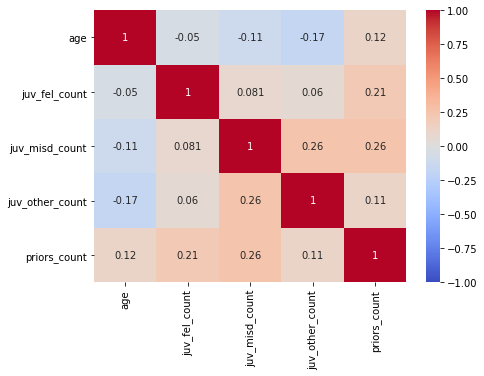

In [251]:
corr_num = X_train.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_num, cmap='coolwarm',vmin=-1, vmax=1, annot=True);

In [252]:
corr_df = corr_num.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head()

,feature_1,feature_2,correlation
13,juv_misd_count,juv_other_count,0.257501
17,juv_other_count,juv_misd_count,0.257501
22,priors_count,juv_misd_count,0.257007
14,juv_misd_count,priors_count,0.257007
9,juv_fel_count,priors_count,0.212775


---

For **ordinal features**, we can use Spearman's rank correlation instead to check whether some **ordinally encoded** features are almost entirely "ordered" similarily than others.

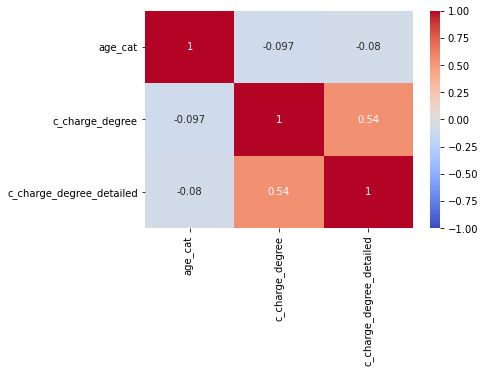

In [253]:
X_ordinally_encoded = pd.DataFrame(preproc_ordinal.fit_transform(X[feat_ordinal]), columns=feat_ordinal)
sns.heatmap(X_ordinally_encoded.corr(method='spearman'), cmap='coolwarm', vmin=-1, vmax=1, annot=True);

- Using Spearman we see a high correlation between `c_charge_degree` and `c_charge_degree_detailed`
- This makes sense, since the `c_charge_degree_detailed` is our engineered feature which is a more granular classification of felonies and misdemeanors. We should therefore drop one of the features
- However, using Spearman only for the ordinally encoded features we can not assess the correlation between `age` and `age_cat` and any possible correlation between `sex` and the other features. This correlation assessment could only been performed after encoding.

---
- In order to assess the correlation between all features we use the transformed and encoded features. 
- We see the high correlation between `age_cat` and `age` and `c_charge_degree` and `c_charge_degree_detailed`

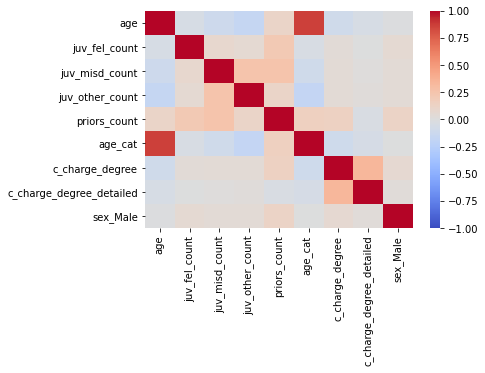

In [255]:
df_enc = pd.DataFrame(preproc.fit_transform(X_train), columns=column_nam)
sns.heatmap(df_enc.corr(), cmap='coolwarm',vmin=-1, vmax=1);

### Assess correlation on complete dataset (including `race` and `y`)

- Identify correlation between all features (including race) and the target 

In [256]:
# Define numerical feature once-for-all for race pipeline
feat_numerical_y = sorted(df_clas.select_dtypes(include=["int64", "float64"]).columns)

In [262]:
#Create preproc pipeline with race and target y
preproc_ra_y = make_column_transformer(
    (preproc_numerical, feat_numerical_y), #stays the same since race is a nominal feature
    (preproc_ordinal, feat_ordinal), #stays the same since race is a nominal feature
    (preproc_nominal_r, feat_nominal_r), 
    remainder="drop")

preproc_ra_y

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'juv_fel_count', 'juv_misd_count',
                                  'juv_other_count', 'priors_count',
                                  'two_year_recid']),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '25',
                                                                              '25 '
                                                                              '- '
                                                                              '45',
                                                                              'Greater '
                                                                              'than '
                                                                              '45'],
                                                                             ['...
                                                                 unknown_value=-1)),
                                                 ('knnimputer',
                                                  KNNImputer(missing_values=-1,
                                                             n_neighbors=25)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age_cat', 'c_charge_degree',
                                  'c_charge_degree_detailed']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['race', 'sex'])])

In [263]:
#Test preproc_ra_y pipeline
preproc_ra_y.fit(df_clean)

column_nam_ra_y = feat_numerical_y + feat_ordinal+ list(preproc_ra_y.named_transformers_["pipeline-3"].named_steps["onehotencoder"].get_feature_names_out(feat_nominal_r))

df_enc_race = pd.DataFrame(preproc_ra_y.transform(df_clean), columns=column_nam_ra_y)

df_enc_race.head(3)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,age_cat,c_charge_degree,c_charge_degree_detailed,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Male
0,0.649351,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.194805,0.0,0.0,0.000000,0.000000,1.0,0.5,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.064935,0.0,0.0,0.111111,0.108108,1.0,0.0,1.0,0.6,1.0,0.0,0.0,0.0,0.0,0.0,1.0


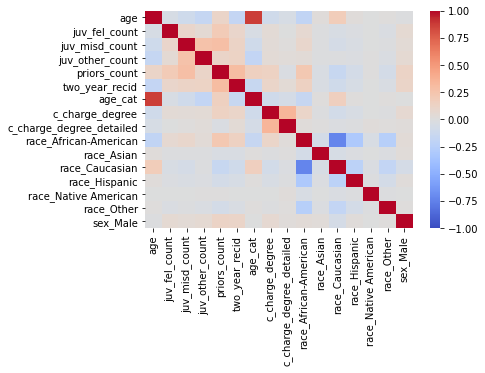

In [265]:
sns.heatmap(df_enc_race.corr(), cmap='coolwarm',vmin=-1, vmax=1);

## Forward Selection using `SequentialFeatureSelector` 

In [283]:
sfs_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
sfs_results = []

In [285]:
for model in sfs_models:
    sfs_forward = SequentialFeatureSelector(model, direction="forward", cv=None)
    pipe_sfs = imblearn_make_pipeline(preproc, smt, sfs_forward, model)
    
    param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

    grid_sfs = GridSearchCV(pipe_sfs, param_grid, 
                              cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

    grid_sfs.fit(X_train, y_train);
    print(str(model))
    print(grid_sfs.best_params_)
    print(grid_sfs.best_score_)
    
    sfs_results.append(grid_sfs)

LogisticRegression(penalty='l1', solver='liblinear')
{'sequentialfeatureselector__n_features_to_select': 7}
0.7366861801317874
LogisticRegression()
{'sequentialfeatureselector__n_features_to_select': 7}
0.7336534599314743
DecisionTreeClassifier()
{'sequentialfeatureselector__n_features_to_select': 3}
0.7082636175889196


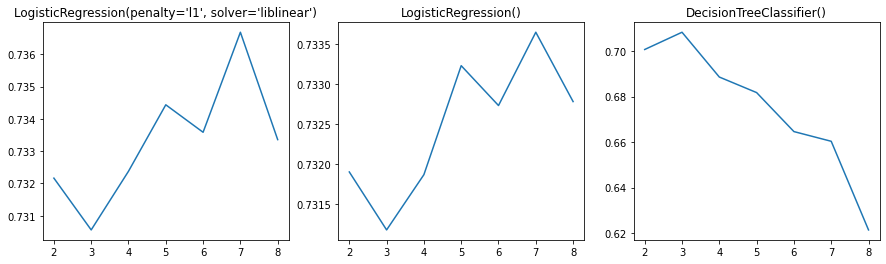

In [301]:
fig,ax = plt.subplots(1,3, figsize=(15,4))
# Check results of gridSearch 
sns.lineplot(x=np.arange(2,9), y=sfs_results[0].cv_results_["mean_test_roc_auc"], ax=ax[0])
ax[0].set_title(str(sfs_models[0]))
sns.lineplot(x=np.arange(2,9), y=sfs_results[1].cv_results_["mean_test_roc_auc"], ax=ax[1])
ax[1].set_title(str(sfs_models[1]))
sns.lineplot(x=np.arange(2,9), y=sfs_results[2].cv_results_["mean_test_roc_auc"], ax=ax[2])
ax[2].set_title(str(sfs_models[2]));

In [307]:
# Print selected features for each model
for i, results in enumerate(sfs_results):
    # Get selected features
    sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

    print(sfs_models[i])
    print(f"Selected columns: {X.columns[sfs_sel_feat]}")
    print()

LogisticRegression(penalty='l1', solver='liblinear')
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'c_charge_degree_detailed'],
      dtype='object')

LogisticRegression()
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'c_charge_degree', 'c_charge_degree_detailed'],
      dtype='object')

DecisionTreeClassifier()
Selected columns: Index(['age', 'juv_misd_count', 'c_charge_degree_detailed'], dtype='object')



Out of the 9 total features the Logisitic Regression models with l1 and l2 penalty 7 were selected, for the DecisionTree only 3 were selected

## Backward Selection using `SequentialFeatureSelector` 

In [309]:
sfs_back_models = [LogisticRegression(solver='liblinear', penalty='l1'), LogisticRegression(), DecisionTreeClassifier()]
sfs_back_results = []

In [310]:
for model in sfs_back_models:
    sfs__b = SequentialFeatureSelector(model, direction="forward", cv=None)
    pipe_sfs_b = imblearn_make_pipeline(preproc, smt, sfs__b, model)
    
    param_grid =  {'sequentialfeatureselector__n_features_to_select': np.arange(2,9)}

    grid_sfs_b = GridSearchCV(pipe_sfs_b, param_grid, 
                              cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

    grid_sfs_b.fit(X_train, y_train);
    print(str(model))
    print(grid_sfs_b.best_params_)
    print(grid_sfs_b.best_score_)
    
    sfs_back_results.append(grid_sfs_b)

LogisticRegression(penalty='l1', solver='liblinear')
{'sequentialfeatureselector__n_features_to_select': 8}
0.7350288066552902
LogisticRegression()
{'sequentialfeatureselector__n_features_to_select': 7}
0.7326487335177291
DecisionTreeClassifier()
{'sequentialfeatureselector__n_features_to_select': 3}
0.6983296497917595


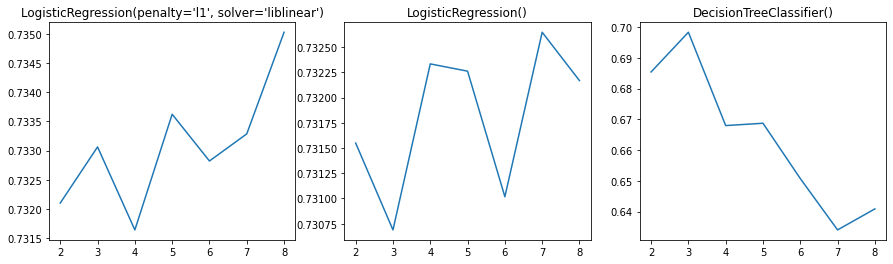

In [311]:
fig,ax = plt.subplots(1,3, figsize=(15,4))
# Check results of gridSearch 
sns.lineplot(x=np.arange(2,9), y=sfs_back_results[0].cv_results_["mean_test_roc_auc"], ax=ax[0])
ax[0].set_title(str(sfs_back_models[0]))
sns.lineplot(x=np.arange(2,9), y=sfs_back_results[1].cv_results_["mean_test_roc_auc"], ax=ax[1])
ax[1].set_title(str(sfs_back_models[1]))
sns.lineplot(x=np.arange(2,9), y=sfs_back_results[2].cv_results_["mean_test_roc_auc"], ax=ax[2])
ax[2].set_title(str(sfs_back_models[2]));

In [312]:
# Print selected features for each model
for i, results in enumerate(sfs_back_results):
    # Get selected features
    sfs_sel_feat = results.best_estimator_.named_steps["sequentialfeatureselector"].get_support()

    print(sfs_back_models[i])
    print(f"Selected columns: {X.columns[sfs_sel_feat]}")
    print()

LogisticRegression(penalty='l1', solver='liblinear')
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'c_charge_degree', 'c_charge_degree_detailed'],
      dtype='object')

LogisticRegression()
Selected columns: Index(['age', 'age_cat', 'sex', 'juv_fel_count', 'juv_misd_count',
       'priors_count', 'c_charge_degree'],
      dtype='object')

DecisionTreeClassifier()
Selected columns: Index(['juv_fel_count', 'juv_misd_count', 'juv_other_count'], dtype='object')



Using backward selection we get a quiet different result. From the 9 possible features X were selected

## Impurity reduction (MDI)

In [313]:
clf_forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, clf_forest)
pipe_forest.fit(X_train, y_train);

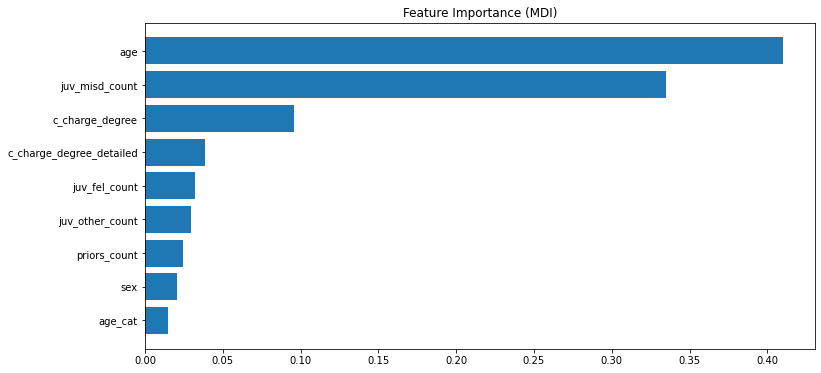

In [314]:
feature_importance = pipe_forest.named_steps["randomforestclassifier"].feature_importances_ 
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)");

Some text

## Feature permutation (MDA)

We want to remove features that, when in combination with all the others, do not really help predict our target.

To do so, we use feature `permutation_importance` importance in combination with an estimator! It trains one pipe per feature, so as to estimate which feature make our performance score *decrease* the most when shuffling it randomly. These would be our most important feature not to remove. 

In [98]:
## Create df instead of plot 

# permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

# importance_df = pd.DataFrame(np.vstack((X_train.columns,
#                                         permutation_score.importances_mean)).T) # Unstack results
# importance_df.columns=['feature','score decrease']

# importance_df.sort_values(by="score decrease", ascending = False) # Order by importance

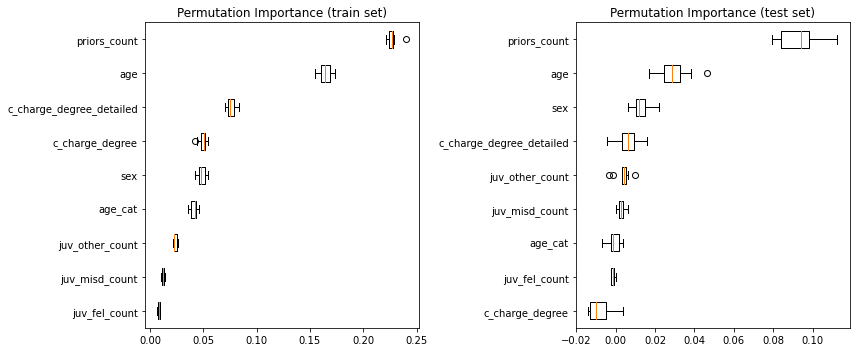

In [315]:
permutation_score = permutation_importance(pipe_forest, X_train, y_train, n_repeats=10) # Perform Permutation

fig = plt.figure(figsize=(12, 5))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score.importances_mean.argsort()
plt.boxplot(
    permutation_score.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (train set)")

#Plot MDA test set
plt.subplot(1, 2, 2)
permutation_score_test = permutation_importance(pipe_forest, X_test, y_test, n_repeats=10)
sorted_idx = permutation_score_test.importances_mean.argsort()
plt.boxplot(
    permutation_score_test.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_test.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

In [ ]:
# Probably only keep train ?

- Using feature permutation, we see that the shuffling the feature `age` (which was also selected by the forward and backward feature selection) significantly leads to a decrease in score
- However, the feature with the highest score decrease `priors count` didn't get selected by the other feature selection techniques, whereas `juv_fel_count`and `juv_misd_count` which got selected do not lead to any score decrease!
- This behavior may be caused by the correlation between the features (e.g. `age` and `age_cat`, `juv_fel_count`, `juv_misd_count` and `priors_count` ...):<br> When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.
- We could decide to only keep the first five features, since we already know that `c_charge_degree_detailed` and `c_charge_degree` are highly correlated

### Test MDA on subset without `c_charge_degree` and `age_cat`

In [320]:
# Create new pipeline without features age_cat and c_charge_degree
feat_ordinal_dict_s = {
#    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
#    "c_charge_degree": ["M", "F"],
    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s = sorted(feat_ordinal_dict_s.keys()) # sort alphabetically
feat_ordinal_values_sorted_s = [feat_ordinal_dict_s[i] for i in feat_ordinal_s]

encoder_ordinal_s = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s = make_pipeline(
    encoder_ordinal_s,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s;

In [321]:
preproc_s = make_column_transformer(
    (preproc_numerical, feat_numerical),
    (preproc_ordinal_s, feat_ordinal_s),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s = make_pipeline(preproc_s, RandomForestClassifier())
pipe_forest_s.fit(X_train, y_train);

In [322]:
permutation_score_s1 = permutation_importance(pipe_forest_s, X_train[feat_numerical + feat_ordinal_s+feat_nominal], y_train, n_repeats=10) # Perform Permutation

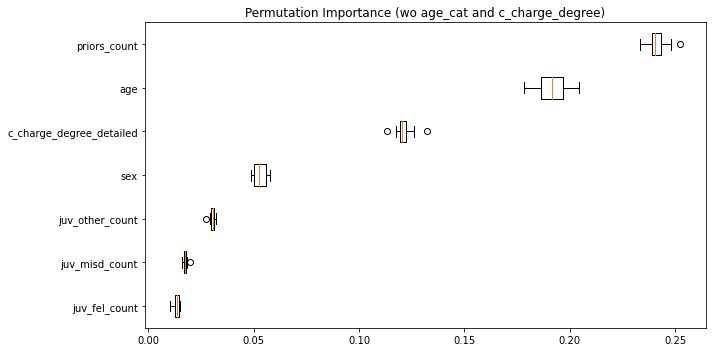

In [325]:
fig = plt.figure(figsize=(10, 5))

sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

fig.tight_layout()
plt.show();

### Test MDA on subset without `c_charge_degree_detailed` and `age`

In [326]:
# Create new pipeline without features c_charge_degree_detailed and age
feat_ordinal_dict_s2 = {
    "age_cat": ["Less than 25", "25 - 45", "Greater than 45"],
    "c_charge_degree": ["M", "F"],
#    "c_charge_degree_detailed": ["0","M2","M1","F3","F2","F1"],
#    "score_text": ["Low", "Medium", "High"],
#    "sex": ["Male","Female"]
    }

feat_ordinal_s2 = sorted(feat_ordinal_dict_s2.keys()) # sort alphabetically
feat_ordinal_values_sorted_s2 = [feat_ordinal_dict_s2[i] for i in feat_ordinal_s2]

encoder_ordinal_s2 = OrdinalEncoder(
    categories=feat_ordinal_values_sorted_s2,
    dtype= np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 # Considers unknown values as worse than missing
)

preproc_ordinal_s2 = make_pipeline(
    encoder_ordinal_s2,
    KNNImputer(missing_values=-1, n_neighbors=25), #kNN impute missing values
#    StandardScaler()
    MinMaxScaler()
)

preproc_ordinal_s2;

In [327]:
# Define numerical feature once-for-all
feat_numerical_s2 = sorted(X.select_dtypes(include=["int64", "float64"]).columns)
feat_numerical_s2.remove("age") #Remove age from list of numerical features

preproc_numerical_s2 = make_pipeline(
    SimpleImputer(),
#    StandardScaler(),
    MinMaxScaler()
)

In [328]:
preproc_s2 = make_column_transformer(
    (preproc_numerical_s2, feat_numerical_s2),
    (preproc_ordinal_s2, feat_ordinal_s2),
    (preproc_nominal, feat_nominal),
    remainder="drop")

pipe_forest_s2 = make_pipeline(preproc_s2, RandomForestClassifier())
pipe_forest_s2.fit(X_train, y_train);

In [329]:
permutation_score_s2 = permutation_importance(pipe_forest_s2, X_train[feat_numerical_s2 + feat_ordinal_s2 +feat_nominal], y_train, n_repeats=10) # Perform Permutation

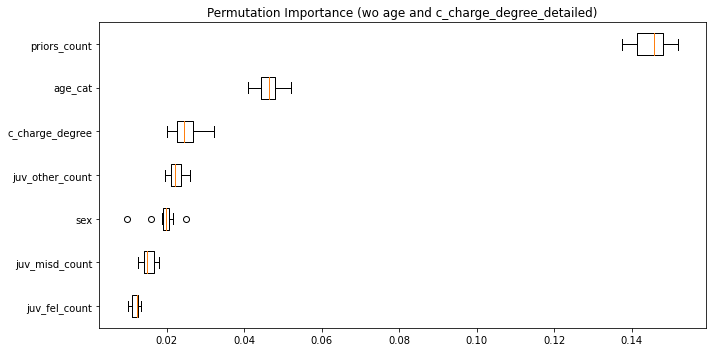

In [330]:
fig = plt.figure(figsize=(10, 5))

sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2 +feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

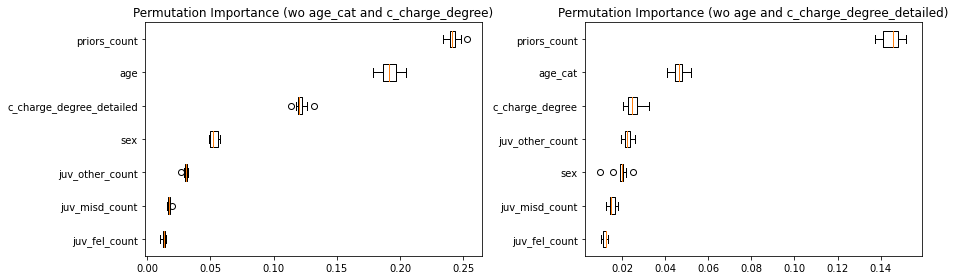

In [331]:
# Both plots side by side
fig = plt.figure(figsize=(13,4))

#Plot MDA train set
plt.subplot(1, 2, 1)
sorted_idx = permutation_score_s1.importances_mean.argsort()
plt.boxplot(
    permutation_score_s1.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical + feat_ordinal_s+feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age_cat and c_charge_degree)")

plt.subplot(1, 2, 2)
sorted_idx = permutation_score_s2.importances_mean.argsort()
plt.boxplot(
    permutation_score_s2.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feat_numerical_s2 + feat_ordinal_s2 +feat_nominal)[sorted_idx],
)
plt.title("Permutation Importance (wo age and c_charge_degree_detailed)")

fig.tight_layout()
plt.show();

- We see more important features in the subset with `age` and `c_charge_degree_detailed`
- Removing `age_cat` and `c_charge_degree` also led to an increase of the overall importance for the other features

# Model iteration

## Logistic Regression

### Untuned Logistic Regression

In [363]:
model_name = "Vanilla Logistic Regression"
logreg = LogisticRegression()
pipe_log = imblearn_make_pipeline(preproc, smt, logreg) ##Create pipeline

In [364]:
cv_logreg = cross_validate(pipe_log, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [336]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_logreg)

In [337]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_logreg['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_logreg['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla Logistic Regression: 0.68
10 fold cv ROC AUC score of Vanilla Logistic Regression: 0.73


In [369]:
pipe_log.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_log

In [368]:
y_pred = pipe_log.predict(X_test)
roc_auc_score(y_test, y_pred)

0.663448170498816

In [366]:
confusion_matrix(y_test, y_pred)

array([[702, 305],
       [215, 370]])

In [344]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1007
           1       0.55      0.63      0.59       585

    accuracy                           0.67      1592
   macro avg       0.66      0.66      0.66      1592
weighted avg       0.68      0.67      0.68      1592



### Tuned Logistic Regression

In [371]:
model_name = "Tuned Logistic Regression"

The `l2` solvers are calculated separately to the `elasticnet`, because these solvers do not work with `l1`

In [349]:
param_grid = [# Param grid for Elasticnet
              {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)},
              # Param grid for different l2 solvers
              {'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
               'logisticregression__C': np.linspace(2.6,2.9,10),
              }
             ]

In [352]:
grid_logreg_tuned = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [355]:
grid_logreg_tuned.fit(X_train, y_train);

# Store trained model
dict_models[model_name]=grid_logreg_tuned.best_estimator_

print(grid_logreg_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_logreg_tuned.best_score_, 2)}")

KeyboardInterrupt: 

In [354]:
grid_models_list.append(model_name)
grid_results_list.append(grid_logreg_tuned)

In [358]:
y_pred = grid_logreg_tuned.predict(X_test)
roc_auc_score(y_test, y_pred)

0.664246004464475

In [360]:
confusion_matrix(y_test, y_pred)

array([[694, 313],
       [211, 374]])

In [359]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.77      0.69      0.73      1007
    is_recid       0.54      0.64      0.59       585

    accuracy                           0.67      1592
   macro avg       0.66      0.66      0.66      1592
weighted avg       0.69      0.67      0.68      1592



Some explanation

## Single tree models

Now let's look at Trees. For our project we analyzed following models:
- Vanilla Decision Trees
- Tuned Decision Tree
- Bagged Tuned Decision Tree
- Vanilla Random Forest
- Tuned Random Forest
- Tuned XGB Classifier

### Single "vanilla" tree model

In [374]:
model_name = "Vanilla single Tree"
tree = DecisionTreeClassifier(max_depth=3)
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [375]:
cv_tree = cross_validate(pipe_tree, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [376]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_tree)

In [377]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_tree['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_tree['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla single Tree: 0.67
10 fold cv ROC AUC score of Vanilla single Tree: 0.71


In [378]:
pipe_tree.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_tree

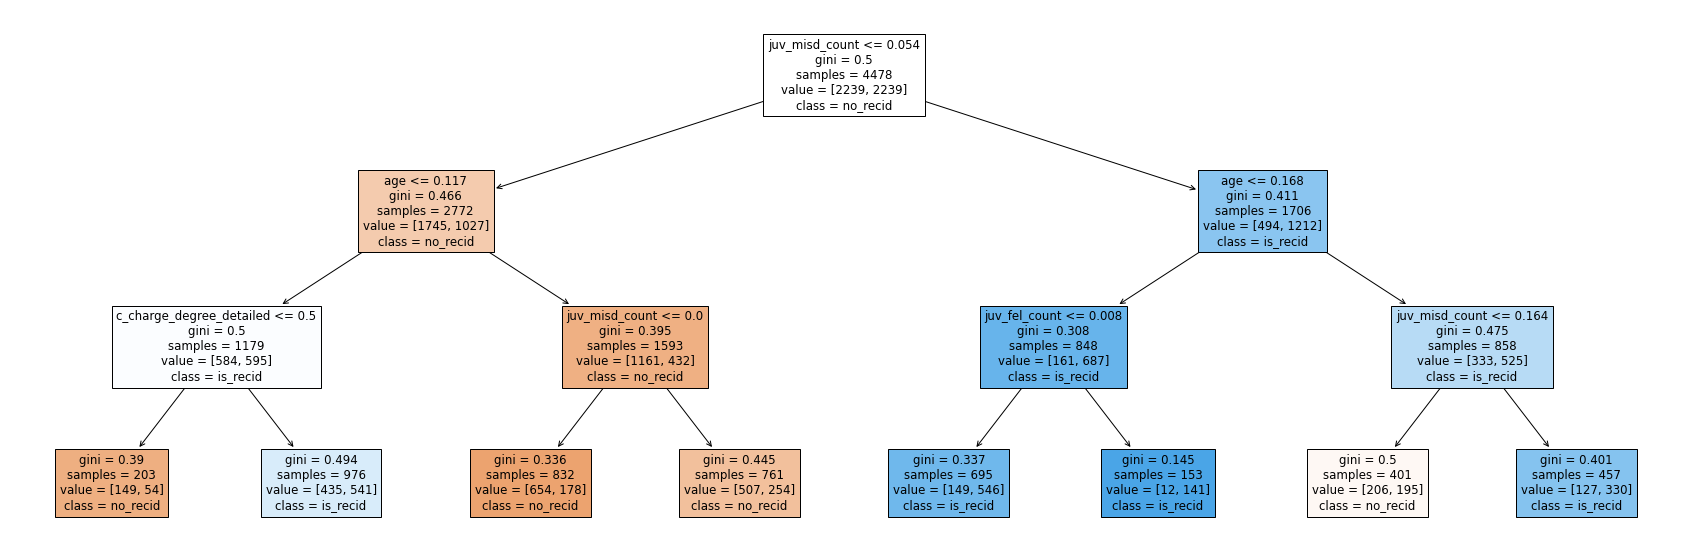

In [382]:
plt.figure(figsize=(30,10))
plot_tree(pipe_tree["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [379]:
y_pred = pipe_tree.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6583445793972109

In [380]:
confusion_matrix(y_test, y_pred)

array([[689, 318],
       [215, 370]])

In [381]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.76      0.68      0.72      1007
    is_recid       0.54      0.63      0.58       585

    accuracy                           0.67      1592
   macro avg       0.65      0.66      0.65      1592
weighted avg       0.68      0.67      0.67      1592



Some comments

### Single hyperparameter-tuned tree

In [387]:
model_name = "Tuned single Tree"
tree = DecisionTreeClassifier()
pipe_tree = imblearn_make_pipeline(preproc, smt, tree) ##Create pipeline

In [424]:
#Grid Search
param_grid =  {'decisiontreeclassifier__max_depth': np.arange(2,4),
               'decisiontreeclassifier__min_samples_split': np.arange(2,15,2),
               'decisiontreeclassifier__min_samples_leaf': np.arange(1,100, 20),
               'decisiontreeclassifier__max_features': [None, "sqrt", "log2"]
               }

In [425]:
grid_tree_tuned = GridSearchCV(pipe_tree, param_grid, #n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [426]:
grid_tree_tuned.fit(X_train, y_train);

print(grid_tree_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_tree_tuned.best_score_, 2)}")

{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__min_samples_leaf': 81, 'decisiontreeclassifier__min_samples_split': 8}
10 fold cv ROC AUC score of Tuned single Tree: 0.71


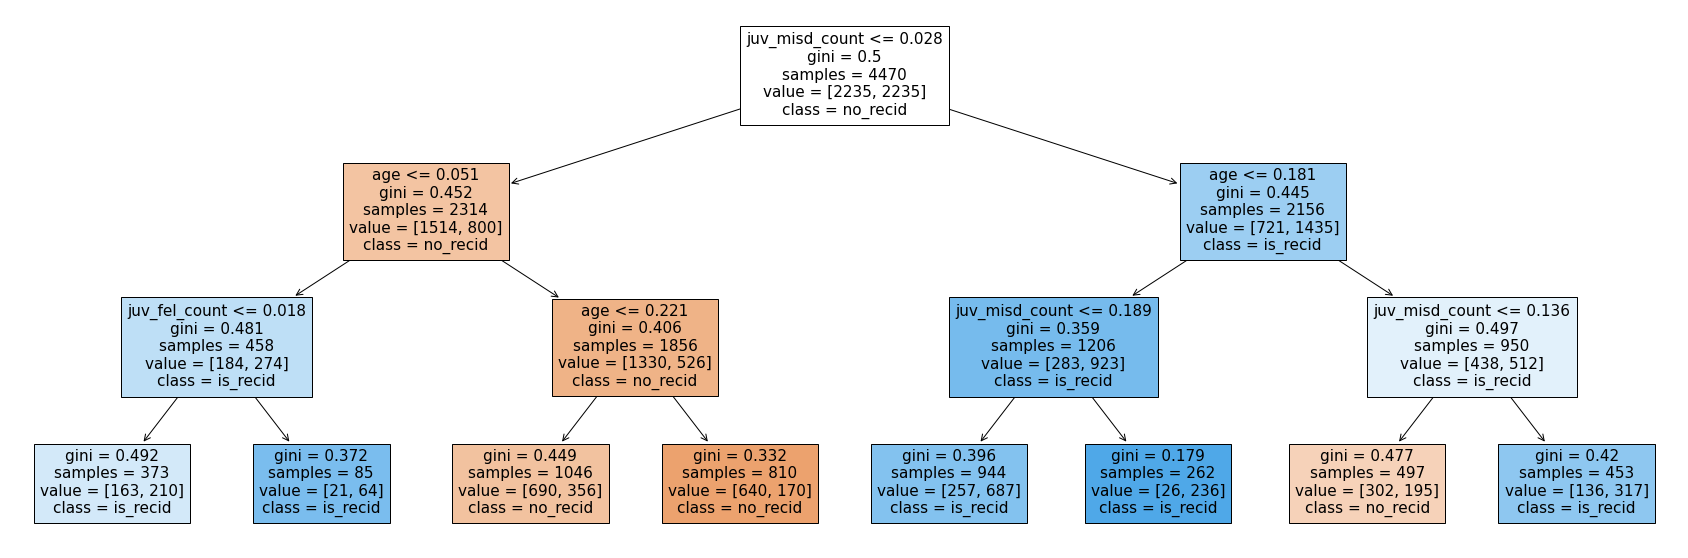

In [428]:
plt.figure(figsize=(30,10))
plot_tree(grid_tree_tuned.best_estimator_["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [429]:
# Store trained model and cv_results
dict_models[model_name]=grid_tree_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_tree_tuned)

In [435]:
y_pred = grid_tree_tuned.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6709529023332401

In [436]:
confusion_matrix(y_test, y_pred)

array([[723, 284],
       [220, 365]])

In [437]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.77      0.72      0.74      1007
    is_recid       0.56      0.62      0.59       585

    accuracy                           0.68      1592
   macro avg       0.66      0.67      0.67      1592
weighted avg       0.69      0.68      0.69      1592



Some comments

## Bagged Tuned Decision Tree

In [454]:
# Create dict of params for instantiating best Decision Tree (based on GridSearch) to use as base estimator in Bagged Tree
best_params_old = grid_tree_tuned.best_params_
best_params_new = {key[len("decisiontreeclassifier__"):]: value for key, value in best_params_old.items()}

In [455]:
model_name = "Bagged tuned single Tree"
base_estimator=DecisionTreeClassifier(**best_params_new) # Instantiate best model from gridsearch
bagged_tree = BaggingClassifier(base_estimator=DecisionTreeClassifier(**best_params_new), n_estimators=501)
pipe_bagtree = imblearn_make_pipeline(preproc, smt, bagged_tree) ##Create pipeline

In [493]:
#Grid Search
param_grid =  {'baggingclassifier__n_estimators': [320],
               'baggingclassifier__max_samples': [0.5],
               'baggingclassifier__max_features': [0.6],
               'baggingclassifier__oob_score': [False]
               }

In [494]:
grid_bagtree = GridSearchCV(pipe_bagtree, param_grid,# n_iter=10,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [495]:
grid_bagtree.fit(X_train, y_train);

print(grid_bagtree.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_bagtree.best_score_, 2)}")

{'baggingclassifier__max_features': 0.6, 'baggingclassifier__max_samples': 0.5, 'baggingclassifier__n_estimators': 320, 'baggingclassifier__oob_score': False}
10 fold cv ROC AUC score of Bagged tuned single Tree: 0.74


In [501]:
# Store trained model and cv_results
dict_models[model_name]=grid_bagtree.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_bagtree)

In [502]:
y_pred = grid_bagtree.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6771802510630713

In [503]:
confusion_matrix(y_test, y_pred)

array([[708, 299],
       [204, 381]])

In [505]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.78      0.70      0.74      1007
    is_recid       0.56      0.65      0.60       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



## Random Forests

### Untuned Random Forest

In [543]:
model_name = "Vanilla random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [544]:
cv_forest = cross_validate(pipe_forest, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [545]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_forest['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_forest['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Vanilla random forest: 0.65
10 fold cv ROC AUC score of Vanilla random forest: 0.66


In [547]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_forest)

In [548]:
pipe_forest.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_forest

In [549]:
y_pred = pipe_forest.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6292677751466231

In [550]:
confusion_matrix(y_test, y_pred)

array([[732, 275],
       [274, 311]])

In [551]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.73      0.73      0.73      1007
    is_recid       0.53      0.53      0.53       585

    accuracy                           0.66      1592
   macro avg       0.63      0.63      0.63      1592
weighted avg       0.66      0.66      0.66      1592



### Tuned Random Forest

In [552]:
model_name = "Tuned random forest"
forest = RandomForestClassifier()
pipe_forest = imblearn_make_pipeline(preproc, smt, forest) ##Create pipeline

In [563]:
#Grid Search
param_grid =  {'randomforestclassifier__n_estimators':[500,750,1000],
               'randomforestclassifier__max_depth': np.arange(8,10,1), #np.arange(2,4),
               'randomforestclassifier__min_samples_split': np.arange(30,45,5), #np.arange(2,15,2),
               'randomforestclassifier__min_samples_leaf': np.arange(80,90, 2),
               'randomforestclassifier__max_features': [None, "log2"],
               'randomforestclassifier__oob_score':[True]
               }

In [564]:
grid_forest_tuned = RandomizedSearchCV(pipe_forest, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [565]:
grid_forest_tuned.fit(X_train, y_train);

print(grid_forest_tuned.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_forest_tuned.best_score_, 2)}")

{'randomforestclassifier__oob_score': True, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 40, 'randomforestclassifier__min_samples_leaf': 84, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 8}
10 fold cv ROC AUC score of Tuned random forest: 0.74


In [566]:
# Store trained model and cv_results
dict_models[model_name]=grid_forest_tuned.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_forest_tuned)

In [567]:
y_pred = grid_forest_tuned.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6815598502788175

In [568]:
confusion_matrix(y_test, y_pred)

array([[691, 316],
       [189, 396]])

In [569]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.79      0.69      0.73      1007
    is_recid       0.56      0.68      0.61       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



## XGB Boosting Classifier

### Untuned XGB Boosting Classifier

In [507]:
model_name = "Untuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [508]:
cv_XGB = cross_validate(pipe_XGB, X_train, y_train, scoring=clf_scoring, cv=10, n_jobs=-1)

In [509]:
print(f"10 fold cv accuracy of {model_name}: {np.round(cv_XGB['test_accuracy'].mean(),2)}")
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(cv_XGB['test_roc_auc'].mean(),2)}")

10 fold cv accuracy of Untuned XGB: 0.68
10 fold cv ROC AUC score of Untuned XGB: 0.69


In [510]:
# Store results and model name for later comparison
cv_models_list.append(model_name)
cv_results_list.append(cv_XGB)

In [511]:
pipe_XGB.fit(X_train, y_train)

# Store trained model
dict_models[model_name]=pipe_XGB

[18:29:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Tuned XGB Boosting Classifiert

In [532]:
model_name = "Tuned XGB"
xgb_model = XGBClassifier(use_label_encoder=False)
pipe_XGB = imblearn_make_pipeline(preproc, smt, xgb_model) ##Create pipeline

In [533]:
# Grid Search
param_grid = {
    'xgbclassifier__n_estimators':[30],
    'xgbclassifier__min_child_weight':[3,4,5], 
    'xgbclassifier__gamma':[i/10.0 for i in range(3,6)],
    'xgbclassifier__reg_alpha':[0.1],
    'xgbclassifier__subsample':[0.5,0.7,0.1],
    'xgbclassifier__colsample_bytree':[0.8], 
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__objective': ['binary:logistic'],
    'xgbclassifier__booster': ['gbtree'],
    'xgbclassifier__eval_metric': ['auc'],
    'xgbclassifier__eta': [i/10.0 for i in range(3,5)],
    'xgbclassifier__learning_rate':[0.01,0.1,0.01],
    }

In [534]:
grid_XGB = RandomizedSearchCV(pipe_XGB, param_grid, n_iter=100,
                          cv=10, n_jobs=-1, scoring=clf_scoring, refit="roc_auc")

In [536]:
grid_XGB.fit(X_train, y_train);

print(grid_XGB.best_params_)
print(f"10 fold cv ROC AUC score of {model_name}: {np.round(grid_XGB.best_score_, 2)}")


[18:49:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:49:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:49:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:49:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:49:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:50:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:50:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:50:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:50:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:50:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:56:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:56:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:57:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:57:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:57:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:57:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:57:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:58:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:58:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:58:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:58:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:58:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:58:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:59:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su


[18:59:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "su

{'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_alpha': 0.1, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__n_estimators': 30, 'xgbclassifier__min_child_weight': 3, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__eta': 0.4, 'xgbclassifier__colsample_bytree': 0.8, 'xgbclassifier__booster': 'gbtree'}
10 fold cv ROC AUC score of Tuned XGB: 0.74


In [538]:
# Store trained model and cv_results
dict_models[model_name]=grid_XGB.best_estimator_
grid_models_list.append(model_name)
grid_results_list.append(grid_XGB)

In [540]:
y_pred = grid_XGB.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6671436695269863

In [541]:
confusion_matrix(y_test, y_pred)

array([[705, 302],
       [214, 371]])

In [542]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.77      0.70      0.73      1007
    is_recid       0.55      0.63      0.59       585

    accuracy                           0.68      1592
   macro avg       0.66      0.67      0.66      1592
weighted avg       0.69      0.68      0.68      1592



# Comparing results and choosing best model

## Compare cross validated metrics

In [575]:
# Transform cv-results 
cv_results_trans = save_cv_results(cv_results_list, cv_models_list)
grid_results_trans = save_grid_cv_results(grid_results_list, grid_models_list, clf_scoring)

cv_results_df = pd.concat(cv_results_trans+grid_results_trans, ignore_index=True)

In [581]:
# Create df for plotting
cv_results_plot = pd.melt(cv_results_df, id_vars=['model'], var_name='metrics', value_name='values')

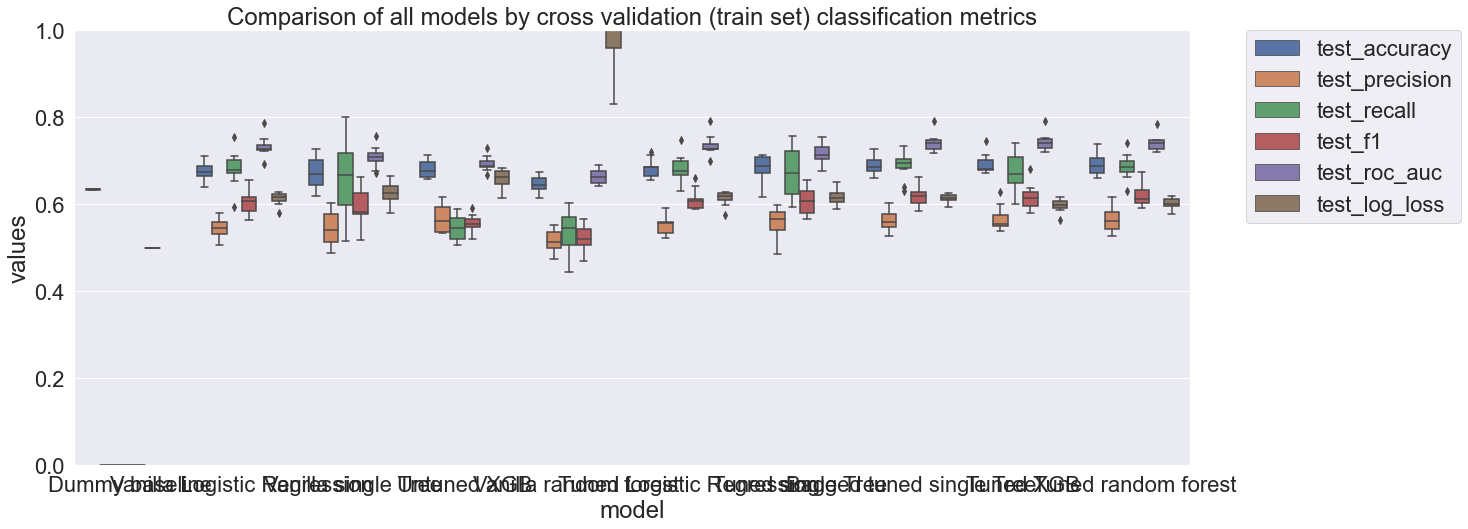

In [645]:
# Show results of all models
plt.figure(figsize=(20, 8))
sns.boxplot(x="model", y="values", hue="metrics", data=cv_results_plot)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of all models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

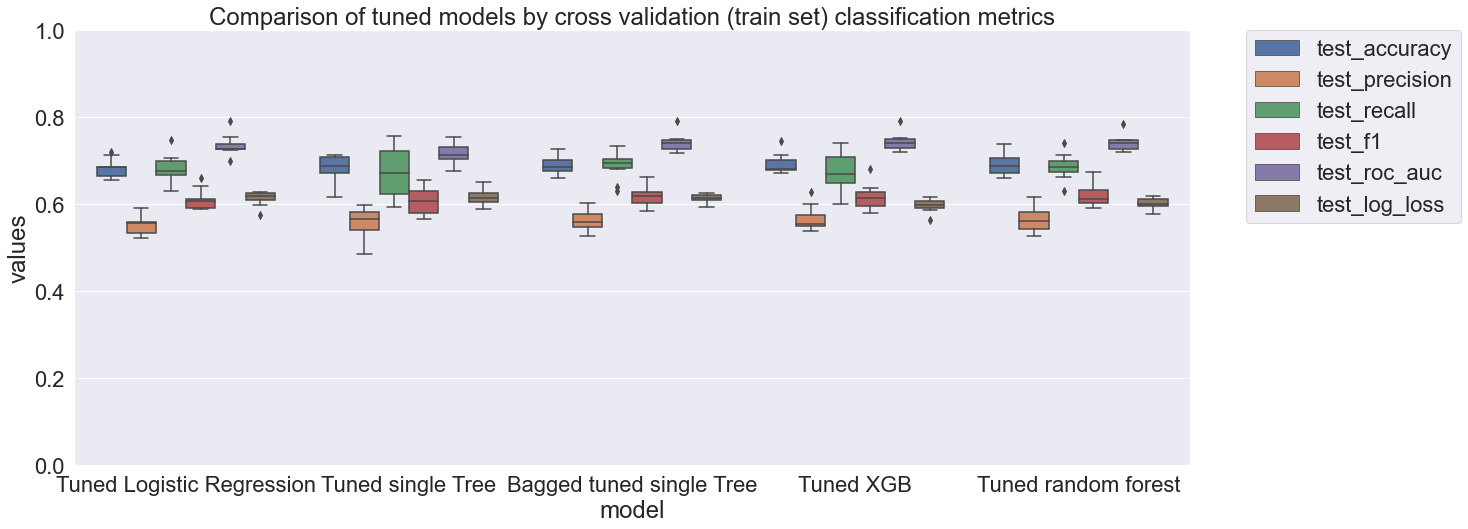

In [643]:
# Show results of tuned models only
df_plot_tuned = cv_results_plot[(cv_results_plot['model'].isin(["Tuned Logistic Regression", "Tuned single Tree", "Bagged tuned single Tree", "Tuned random forest", "Tuned XGB"]))].copy()

plt.figure(figsize=(20, 8))
sns.boxplot(x="model", y="values", hue="metrics", data=df_plot_tuned)#, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.title('Comparison of tuned models by cross validation (train set) classification metrics');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

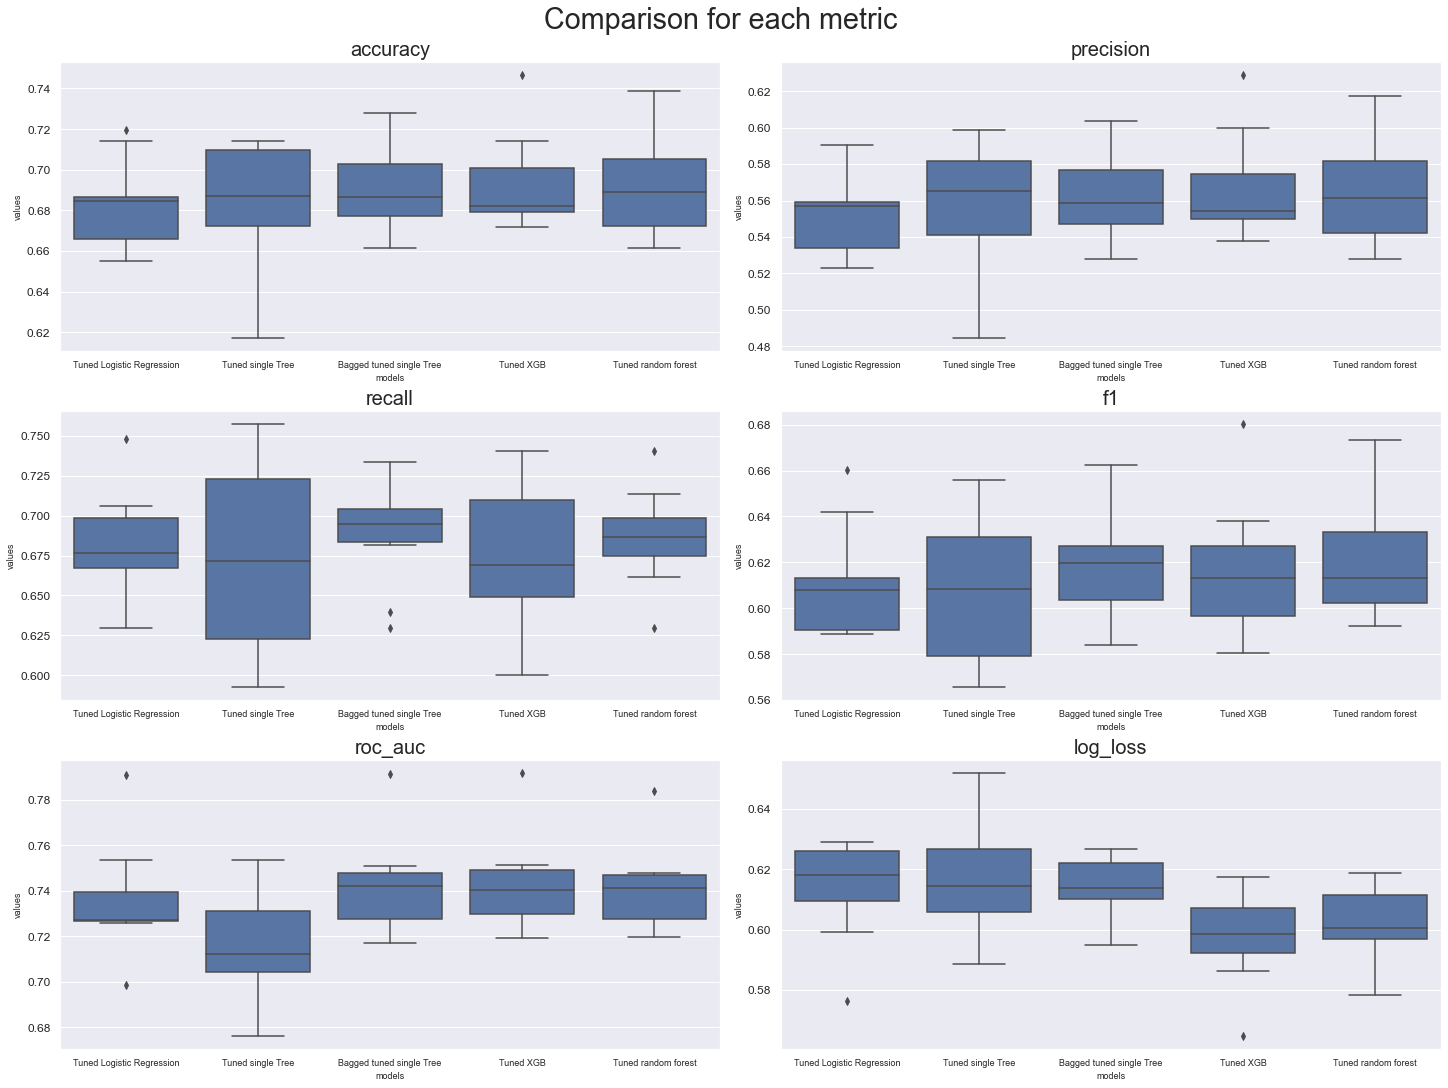

In [662]:
#
fig, ax = plt.subplots(3,2, figsize=(20,15), constrained_layout=True)
fig.suptitle('Comparison for each metric ')
ax = ax.ravel()

for i, metric in enumerate(df_plot_tuned.metrics.unique()):
    sns.boxplot(x="model", y="values", hue="metrics", 
                data=df_plot_tuned[df_plot_tuned["metrics"]==metric], ax=ax[i])    
    ax[i].set_title(metric[5:], fontsize=20)
    ax[i].set_xlabel("models", fontsize=9)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].tick_params(labelsize=12)
    ax[i].legend([],[], frameon=False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=9)

Some explanations

## Calculate and compare test scores

In [675]:
# Filter df for tuned models
keys = ["Tuned Logistic Regression", "Tuned single Tree", "Bagged tuned single Tree", "Tuned random forest", "Tuned XGB"]
dict_tuned = {nk: dict_models[nk] for nk in keys}

In [693]:
metrics_names = clf_scoring
metrics_names[-1]="log_loss"
test_metrics = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss]
metrics_dict = dict(zip(metrics_names, test_metrics))

In [696]:
dict_test ={}
for me_name, metric in metrics_dict.items():
    test_scores = []
    for model in dict_tuned.values():
        y_pred = model.predict(X_test)
        test_scores.append(metric(y_test, y_pred))
    dict_test[me_name]=test_scores

In [710]:
test_scores_df = pd.DataFrame(dict_test, index=keys)
test_scores_df

,accuracy,precision,recall,f1,roc_auc,log_loss
Tuned Logistic Regression,0.670854,0.544396,0.639316,0.588050,0.664246,11.368448
Tuned single Tree,0.683417,0.562404,0.623932,0.591572,0.670953,10.934529
Bagged tuned single Tree,0.684045,0.560294,0.651282,0.602372,0.677180,10.912841
Tuned random forest,0.682789,0.556180,0.676923,0.610640,0.681560,10.956240
Tuned XGB,0.675879,0.551263,0.634188,0.589825,0.667144,11.194881


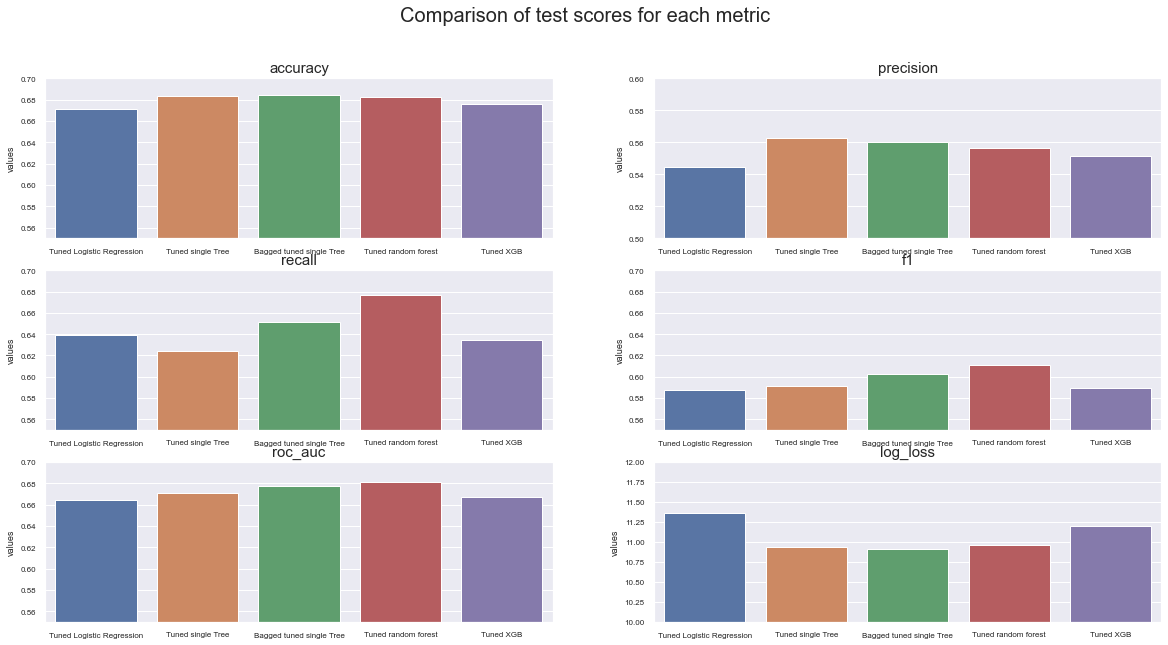

In [737]:
#
fig, ax = plt.subplots(3,2, figsize=(20,10))
fig.suptitle('Comparison of test scores for each metric', fontsize=20)
ax = ax.ravel()

for i, metric in enumerate(test_scores_df.columns):
    sns.barplot(x=test_scores_df.index, y=metric, data=test_scores_df, ax=ax[i])    
    ax[i].tick_params(labelsize=8)
    ax[i].set_ylabel("values", fontsize=9)
    ax[i].set_title(metric, fontsize=15)
    
    if i == 5:
        ax[i].set_ylim(10,12)
    elif i==1:
        ax[i].set_ylim(0.5,0.6)
    else:
        ax[i].set_ylim(0.55,0.7)

# Backup

### Single tuned tree with forward feature selection

In [130]:
best_sfs_forward = SequentialFeatureSelector(LogisticRegression(), direction="forward", n_features_to_select=3)

In [131]:
pipe_sfs_forward = make_pipeline(preproc, best_sfs_forward)

In [132]:
# Create pipe with best parameters from tuned tree model
best_tree = DecisionTreeClassifier(max_depth=5, max_features=None, min_impurity_decrease=0.0, min_samples_leaf=0.01, min_samples_split=2)
pipe_sfs_tree = make_pipeline(pipe_sfs_forward, best_tree)

In [133]:
score_sfs_tree = cross_val_score(pipe_sfs_tree, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_tree.std())
score_sfs_tree.mean()

Standard deviation across different folds: 0.01098365754373015


-0.5794022112899186

In [134]:
pipe_sfs_tree.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                   ('knnimputer',
                                                                                    KNNImputer(missing_values=-1,
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(estimator=LogisticRegression(),
                                                            n_features_to_select=3))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))])

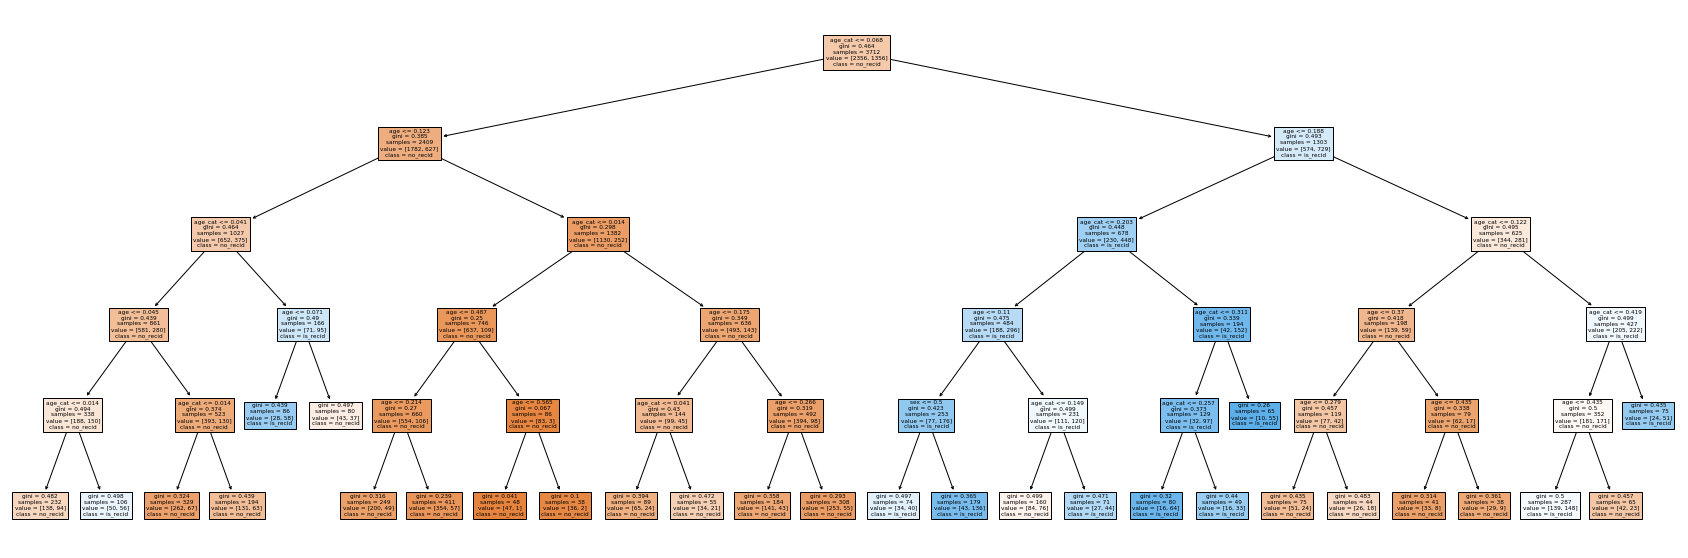

In [135]:
plt.figure(figsize=(30,10))
plot_tree(pipe_sfs_tree["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [136]:
y_pred = pipe_sfs_tree.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6349154211120448

In [137]:
confusion_matrix(y_test, y_pred)

array([[826, 181],
       [322, 263]])

In [138]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.82      0.77      1007
    is_recid       0.59      0.45      0.51       585

    accuracy                           0.68      1592
   macro avg       0.66      0.63      0.64      1592
weighted avg       0.67      0.68      0.67      1592



### Single tuned tree with backward feature selection

In [140]:
pipe_sfs_backward = make_pipeline(preproc, best_sfs_backward)

In [141]:
# Create pipe with best parameters from tuned tree model
best_tree = DecisionTreeClassifier(max_depth=5, max_features=None, min_impurity_decrease=0.0, min_samples_leaf=0.01, min_samples_split=2)
pipe_sfs_tree_back = make_pipeline(pipe_sfs_backward, best_tree)

In [142]:
score_sfs_tree_back = cross_val_score(pipe_sfs_tree_back, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_tree_back.std())
score_sfs_tree_back.mean()

Standard deviation across different folds: 0.014523492697776303


-0.5803269878201683

In [143]:
pipe_sfs_tree_back.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                    KNNImputer(missing_values=-1,
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(direction='backward',
                                                            estimator=LogisticRegression(),
                                                            n_features_to_select=6))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.01))])

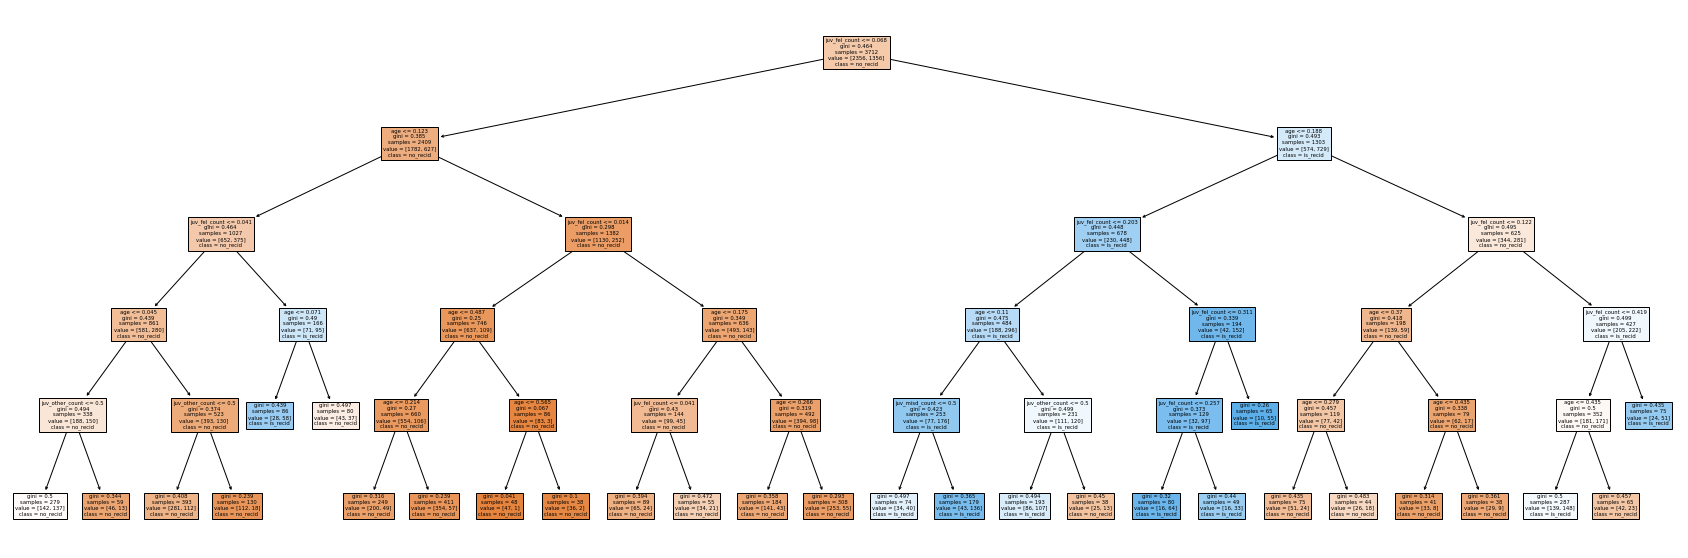

In [144]:
plt.figure(figsize=(30,10))
plot_tree(pipe_sfs_tree_back["decisiontreeclassifier"], 
          feature_names=X_train.columns,  
          class_names=["no_recid", "is_recid"],
          filled=True);

In [145]:
y_pred = pipe_sfs_tree_back.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6393841400792741

In [146]:
confusion_matrix(y_test, y_pred)

array([[835, 172],
       [322, 263]])

In [147]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.72      0.83      0.77      1007
    is_recid       0.60      0.45      0.52       585

    accuracy                           0.69      1592
   macro avg       0.66      0.64      0.64      1592
weighted avg       0.68      0.69      0.68      1592



### Bagged tuned tree with forward feature selection

In [154]:
bagged_tree = BaggingClassifier(base_estimator=best_tree, n_estimators=500)
pipe_tree_bagged_for = make_pipeline(pipe_sfs_forward, bagged_tree)

In [155]:
score_sfs_bagged_tree_for = cross_val_score(pipe_tree_bagged, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", score_sfs_bagged_tree_for.std())
score_sfs_bagged_tree_for.mean()

Standard deviation across different folds: 0.014532671177314266


-0.5708746457434609

In [156]:
pipe_tree_bagged_for.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer()),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age',
                                                                    'juv_fel_count',
                                                                    'juv_misd_count',
                                                                    'juv_other_count',
                                                                    'priors_count']),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('ordinalencoder',
                                                                                    OrdinalEncoder(categories=[['Les...
                                                                                               n_neighbors=25)),
                                                                                   ('minmaxscaler',
                                                                                    MinMaxScaler())]),
                                                                   ['age_cat',
                                                                    'c_charge_degree',
                                                                    'c_charge_degree_detailed',
                                                                    'sex'])])),
                                 ('sequentialfeatureselector',
                                  SequentialFeatureSelector(estimator=LogisticRegression(),
                                                            n_features_to_select=3))])),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                         min_samples_leaf=0.01),
                                   n_estimators=500))])

In [157]:
y_pred = pipe_tree_bagged_for.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6459450513075141

In [158]:
confusion_matrix(y_test, y_pred)

array([[831, 176],
       [312, 273]])

In [159]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.73      0.83      0.77      1007
    is_recid       0.61      0.47      0.53       585

    accuracy                           0.69      1592
   macro avg       0.67      0.65      0.65      1592
weighted avg       0.68      0.69      0.68      1592



## Test MDI Feature Selection step in pipeline

### Logistic Regression on preproc pipeline

In [205]:
#recreate best model to create plot of training loss
test_pipe = make_pipeline(preproc, SelectFromModel(RandomForestClassifier(),threshold=0.04), LogisticRegression(C=1.22, l1_ratio=1,penalty="elasticnet", solver="saga"))
test_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold=0.04)),
                ('logisticregression',
                 LogisticRegression(C=1.22, l1_ratio=1, penalty='elasticnet',
                                    solver='saga'))])

In [206]:
cv_test_pipe = cross_validate(test_pipe, X_train, y_train, scoring="neg_log_loss", cv=10)

In [207]:
cv_test_pipe["test_score"].mean()

-0.5854370855789977

In [208]:
test_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold=0.04)),
                ('logisticregression',
                 LogisticRegression(C=1.22, l1_ratio=1, penalty='elasticnet',
                                    solver='saga'))])

In [209]:
test_pipe.named_steps["selectfrommodel"].get_feature_names_out(column_nam)

array(['age', 'juv_other_count', 'priors_count',
       'c_charge_degree_detailed'], dtype=object)

In [250]:
y_pred = test_pipe.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6237457455928161

In [254]:
f1_score(y_test, y_pred)

0.4483159117305459

In [251]:
confusion_matrix(y_test, y_pred)

array([[924,  83],
       [392, 193]])

In [252]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.70      0.92      0.80      1007
    is_recid       0.70      0.33      0.45       585

    accuracy                           0.70      1592
   macro avg       0.70      0.62      0.62      1592
weighted avg       0.70      0.70      0.67      1592



### Logistic Regression on preproc_s pipeline

In [241]:
#recreate best model to create plot of training loss
test_pipe2 = make_pipeline(preproc_s, SelectFromModel(RandomForestClassifier(),threshold=0.1), LogisticRegression(C=1.22, l1_ratio=1,penalty="elasticnet", solver="saga"))
test_pipe2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1'],
                                                                                              ['...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['c_charge_degree_detailed',
                                                   'sex'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold=0.1)),
                ('logisticregression',
                 LogisticRegression(C=1.22, l1_ratio=1, penalty='elasticnet',
                                    solver='saga'))])

In [242]:
cv_test_pipe2 = cross_validate(test_pipe2, X_train, y_train, scoring="neg_log_loss", cv=10)

In [243]:
cv_test_pipe2["test_score"].mean()

-0.5861613019831066

In [244]:
test_pipe2.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               'M2',
                                                                                               'M1',
                                                                                               'F3',
                                                                                               'F2',
                                                                                               'F1'],
                                                                                              ['...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['c_charge_degree_detailed',
                                                   'sex'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold=0.1)),
                ('logisticregression',
                 LogisticRegression(C=1.22, l1_ratio=1, penalty='elasticnet',
                                    solver='saga'))])

In [255]:
test_pipe2.named_steps["selectfrommodel"].get_feature_names_out(feat_numerical+feat_ordinal_s)

array(['age', 'priors_count', 'c_charge_degree_detailed'], dtype=object)

In [256]:
y_pred = test_pipe2.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6171033534489344

In [257]:
confusion_matrix(y_test, y_pred)

array([[933,  74],
       [405, 180]])

In [258]:
f1_score(y_test, y_pred)

0.4290822407628129

In [259]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.70      0.93      0.80      1007
    is_recid       0.71      0.31      0.43       585

    accuracy                           0.70      1592
   macro avg       0.70      0.62      0.61      1592
weighted avg       0.70      0.70      0.66      1592



## Test balancing (outside of Pipeline)

In [318]:
cv_bagged_tree_bal = cross_val_score(bagged_tree, X_res_t, y_res_t, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", cv_bagged_tree_bal.std())
cv_bagged_tree_bal.mean()

Standard deviation across different folds: 0.02707545893454707


-0.5759354671491349

In [319]:
bagged_tree.fit(X_res_train, y_res_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=0.01),
                  n_estimators=500)

In [321]:
y_pred = bagged_tree.predict(preproc.transform(X_test))

roc_auc_score(y_test, y_pred)

/Users/philippheitmann/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


0.6808434972288

In [322]:
confusion_matrix(y_test, y_pred)

array([[693, 314],
       [191, 394]])

In [323]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.78      0.69      0.73      1007
    is_recid       0.56      0.67      0.61       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



In [324]:
f1_score(y_test, y_pred)

0.6094354215003868

## Test Balancing with Pipeline

In [335]:
from imblearn.pipeline.make_pipeline import make_pipeline

In [336]:
pipe_bal_bagged_tree = make_pipeline(preproc, smt, bagged_tree)

pipe_bal_bagged_tree

In [338]:
cv_pipe_bal_bagged_tree = cross_val_score(pipe_bal_bagged_tree, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", cv_pipe_bal_bagged_tree.std())
cv_pipe_bal_bagged_tree.mean()

Standard deviation across different folds: 0.015058230136885571


-0.6039986415177956

In [339]:
pipe_bal_bagged_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('smotetomek',
                 SMOTETomek(smote=SMOTENC(categorical_features=[1, 2, 7, 8]))),
                ('baggingclassifier',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                         min_samples_leaf=0.01),
                                   n_estimators=500))])

In [340]:
y_pred = pipe_bal_bagged_tree.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6778966041130887

In [341]:
confusion_matrix(y_test, y_pred)

array([[706, 301],
       [202, 383]])

In [349]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.78      0.70      0.74      1007
    is_recid       0.56      0.65      0.60       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



In [343]:
f1_score(y_test, y_pred)

0.6036249014972419

## Test 2 Balancing with Pipeline

In [350]:
pipe_bal_tree = make_pipeline(preproc, smt, tree_model)
pipe_bal_tree

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('smotetomek',
                 SMOTETomek(smote=SMOTENC(categorical_features=[1, 2, 7, 8]))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

### Test with log loss

In [352]:
cv_pipe_bal_tree = cross_val_score(pipe_bal_tree, X_train, y_train, cv=10, scoring="neg_log_loss")
print("Standard deviation across different folds:", cv_pipe_bal_tree.std())
cv_pipe_bal_tree.mean()

Standard deviation across different folds: 0.018407075104334508


-0.6136886319578321

In [353]:
pipe_bal_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('smotetomek',
                 SMOTETomek(smote=SMOTENC(categorical_features=[1, 2, 7, 8]))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [354]:
y_pred = pipe_bal_tree.predict(X_test)

roc_auc_score(y_test, y_pred)

0.675332501548986

In [362]:
log_loss(y_test, y_pred)

10.739261187190639

In [355]:
confusion_matrix(y_test, y_pred)

array([[706, 301],
       [205, 380]])

In [356]:
print(classification_report(y_test, y_pred, target_names=["no_recid", "is_recid"]))

              precision    recall  f1-score   support

    no_recid       0.77      0.70      0.74      1007
    is_recid       0.56      0.65      0.60       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



### Test with roc_auc

In [359]:
cv_pipe_bal_tree = cross_val_score(pipe_bal_tree, X_train, y_train, cv=10, scoring="roc_auc")
print("Standard deviation across different folds:", cv_pipe_bal_tree.std())
cv_pipe_bal_tree.mean()

Standard deviation across different folds: 0.023701657255119062


0.7174474935123707

In [360]:
pipe_bal_tree.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'juv_fel_count',
                                                   'juv_misd_count',
                                                   'juv_other_count',
                                                   'priors_count']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['Less '
                                                                                               'than '
                                                                                               '25',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '45',
                                                                                               'Gr...
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('knnimputer',
                                                                   KNNImputer(missing_values=-1,
                                                                              n_neighbors=25)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age_cat', 'c_charge_degree',
                                                   'c_charge_degree_detailed',
                                                   'sex'])])),
                ('smotetomek',
                 SMOTETomek(smote=SMOTENC(categorical_features=[1, 2, 7, 8]))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [361]:
y_pred = pipe_bal_tree.predict(X_test)

roc_auc_score(y_test, y_pred)

0.6707653264753564

## Functions for storing cv and gridsearch result

### Recreate example from stackoverflow

In [488]:
# Create list for storing results of different models
dfs = []
results = []
names=[]
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'neg_log_loss']
target_names = ['no_recid', 'is_recid']

In [489]:
### Balanced Tree

In [501]:
model = pipe_bal_tree
name = "Balanced_Tree"

In [502]:
cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(name)
print(classification_report(y_test, y_pred, target_names=target_names))

Balanced_Tree
              precision    recall  f1-score   support

    no_recid       0.77      0.70      0.74      1007
    is_recid       0.56      0.65      0.60       585

    accuracy                           0.68      1592
   macro avg       0.67      0.68      0.67      1592
weighted avg       0.70      0.68      0.69      1592



In [503]:
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)

In [504]:
final = this_df

In [505]:
# Subsetting cv_results (exclude time metrics)
time_metrics = ['fit_time','score_time'] # fit time metrics
final_nofit = final.loc[:,~final.columns.isin(time_metrics)].copy()

In [506]:
# Change neg_log_loss to positive number (for plotting) and rename columns
final_nofit["test_neg_log_loss"] = final_nofit["test_neg_log_loss"].abs()
final_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)

In [507]:
# Create df for plot
final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

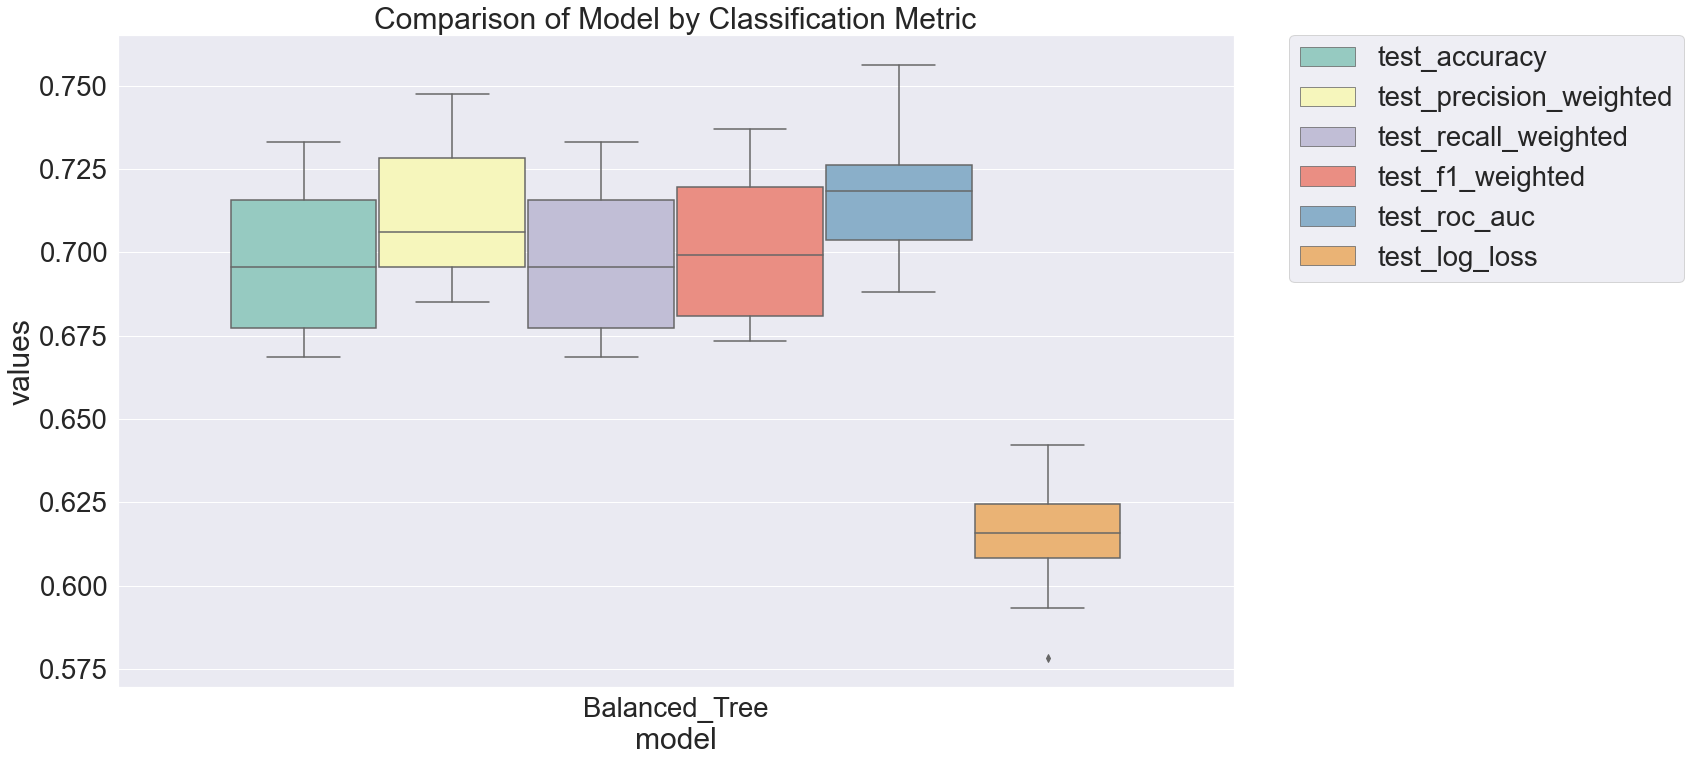

In [508]:
plt.figure(figsize=(20, 12))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=final_nofit_plot, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
### Balanced Log Reg

In [418]:
model = pipe_log
name = "Log_Reg"

In [419]:
#Grid Search
param_grid =  {'logisticregression__penalty': ['elasticnet'],
               'logisticregression__solver': ['saga'],
               'logisticregression__C': np.linspace(1,2,10),
               'logisticregression__l1_ratio': np.arange(0,1.1,0.1)
              }

search_log = GridSearchCV(pipe_log, param_grid, 
                          cv=10, n_jobs=-1, scoring=scoring, refit="roc_auc")

search_log.fit(X_train, y_train);
print(search_log.best_params_)
search_log.best_score_

{'logisticregression__C': 1.3333333333333333, 'logisticregression__l1_ratio': 1.0, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}


0.7349485723287191

In [450]:
# Only get mean reults of GridSearch for best model

# get index of best model 
indx = search_log.cv_results_["params"].index(search_log.best_params_)

# Filter grid search cv results for best model
cv_results_grid = {k:v[indx] for (k,v) in search_log.cv_results_.items() if k.startswith('mean')}
cv_results_grid

{'mean_fit_time': 0.08072445392608643,
 'mean_score_time': 0.07041695117950439,
 'mean_test_accuracy': 0.7039409616555081,
 'mean_test_precision_weighted': 0.6980725005798888,
 'mean_test_recall_weighted': 0.7039409616555081,
 'mean_test_f1_weighted': 0.6759966648130666,
 'mean_test_roc_auc': 0.7349485723287191,
 'mean_test_neg_log_loss': -0.5808007042587179}

In [455]:
# Get results for each split for each metric of GridSearch for best model

# get index of best model 
indx = search_log.cv_results_["params"].index(search_log.best_params_)

# Filter grid search cv results for best model
cv_results_grid = {k:v[indx] for (k,v) in search_log.cv_results_.items() if k.startswith('split')}
cv_results_grid

{'split0_test_accuracy': 0.7123655913978495,
 'split1_test_accuracy': 0.6666666666666666,
 'split2_test_accuracy': 0.7088948787061995,
 'split3_test_accuracy': 0.7169811320754716,
 'split4_test_accuracy': 0.6846361185983828,
 'split5_test_accuracy': 0.7169811320754716,
 'split6_test_accuracy': 0.7115902964959568,
 'split7_test_accuracy': 0.6738544474393531,
 'split8_test_accuracy': 0.7115902964959568,
 'split9_test_accuracy': 0.7358490566037735,
 'split0_test_precision_weighted': 0.7084566091017703,
 'split1_test_precision_weighted': 0.6496212121212122,
 'split2_test_precision_weighted': 0.7001631745605424,
 'split3_test_precision_weighted': 0.7148555158932518,
 'split4_test_precision_weighted': 0.6742189587807264,
 'split5_test_precision_weighted': 0.7172690229426876,
 'split6_test_precision_weighted': 0.7069893956686408,
 'split7_test_precision_weighted': 0.6589422625266689,
 'split8_test_precision_weighted': 0.709087408548325,
 'split9_test_precision_weighted': 0.7411214456550623,
 

In [461]:
col_dict = ['test_accuracy', 'test_precision_weighted',
       'test_recall_weighted', 'test_f1_weighted', 'test_roc_auc',
       'test_neg_log_loss']

In [470]:
# Creat dict for plotting with results for each split for each metric of GridSearch for best model
dicto = {}
for col in col_dict:
    for (k,v) in cv_results_grid.items():
        if k.endswith(col):
            dicto.setdefault(col, []).append(v)

In [478]:
dicto_df = pd.DataFrame(dicto)
dicto_df["model"]=name

# Change neg_log_loss to positive number (for plotting) and rename columns
dicto_df["test_neg_log_loss"] = dicto_df["test_neg_log_loss"].abs()
dicto_df.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)

In [480]:
test_plot = pd.concat([final_nofit,dicto_df], ignore_index=True)

In [483]:
test_plot_p = pd.melt(test_plot, id_vars=['model'], var_name='metrics', value_name='values')

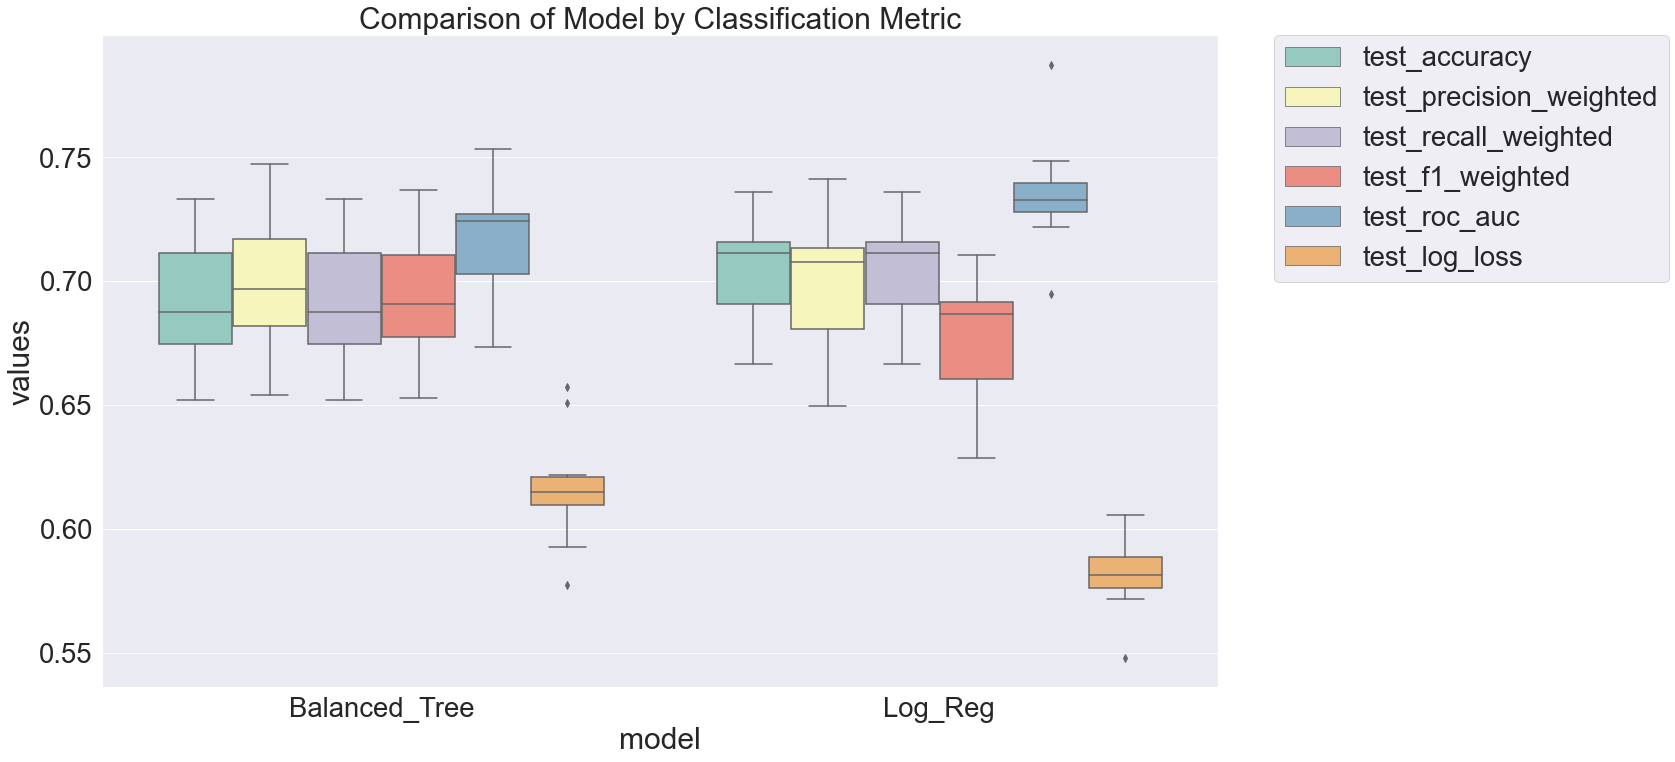

In [484]:
plt.figure(figsize=(20, 12))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=test_plot_p, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric');
#plt.savefig('./benchmark_models_performance.png',dpi=300)

## Function for storing cv models

In [578]:
#test
results = [cv_results, cv_results]
model_names=["Baseline Tree", "Baseline Tree"]

In [579]:
def save_cv_results(cv_results_list, model_name_list):
    '''Store cv results for all splits and metrics as a list of df'''
    cv_results_df=[]
    
    for i, cv_results in enumerate(cv_results_list):
    
        cv_results = pd.DataFrame(cv_results)

        # Subsetting cv_results (exclude time metrics)
        time_metrics = ['fit_time','score_time'] # fit time metrics
        cv_results_nofit = cv_results.loc[:,~cv_results.columns.isin(time_metrics)].copy()

        # Change neg_log_loss to positive number (for plotting) and rename columns
        cv_results_nofit["test_neg_log_loss"] = cv_results_nofit["test_neg_log_loss"].abs()
        cv_results_nofit.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
        cv_results_nofit["model"]=model_name_list[i]
        
        cv_results_df.append(cv_results_nofit)
        
    
    return cv_results_df
    # Create df for plot
    #final_nofit_plot = pd.melt(final_nofit, id_vars=['model'], var_name='metrics', value_name='values')

In [580]:
#test
te1 = save_cv_results(results, model_names)

## Function for storing Grid cv results

In [581]:
results_grid = [search_log, search_log]
model_names_grid=["Logistic Regression", "Logistic Regression"]

In [582]:
def save_grid_cv_results(grid_model_list, model_name_grid_list):
    '''Store cv results for each split for each metric of GridSearch of best model as list of df'''
    grid_cv_results_df=[]
    
    for i, grid_model in enumerate(grid_model_list):

        # get index of best model 
        indx = grid_model.cv_results_["params"].index(grid_model.best_params_)

        # Filter grid search cv results for best model
        cv_results_grid = {k:v[indx] for (k,v) in grid_model.cv_results_.items() if k.startswith('split')}

        #scoring metrics 
        col_dict = ['test_accuracy', 'test_precision_weighted',
           'test_recall_weighted', 'test_f1_weighted', 'test_roc_auc',
           'test_neg_log_loss']

        # Creat dict for plotting with results for each split for each metric of GridSearch for best model
        final_dict = {}
        for col in col_dict:
            for (k,v) in cv_results_grid.items():
                if k.endswith(col):
                    final_dict.setdefault(col, []).append(v)

        df_final = pd.DataFrame(final_dict)
        df_final["model"]=model_name_grid_list[i]

        # Change neg_log_loss to positive number (for plotting) and rename columns
        df_final["test_neg_log_loss"] = df_final["test_neg_log_loss"].abs()
        df_final.rename(columns={"test_neg_log_loss": "test_log_loss"}, inplace=True)
    
        grid_cv_results_df.append(df_final)
        
    
    return grid_cv_results_df


In [583]:
te2 = save_grid_cv_results(results_grid, model_names_grid)

## Combining both results and plot metrics

In [594]:
te4 = pd.concat(te1+te2, ignore_index=True)

In [597]:
te5 = pd.melt(te4, id_vars=['model'], var_name='metrics', value_name='values')

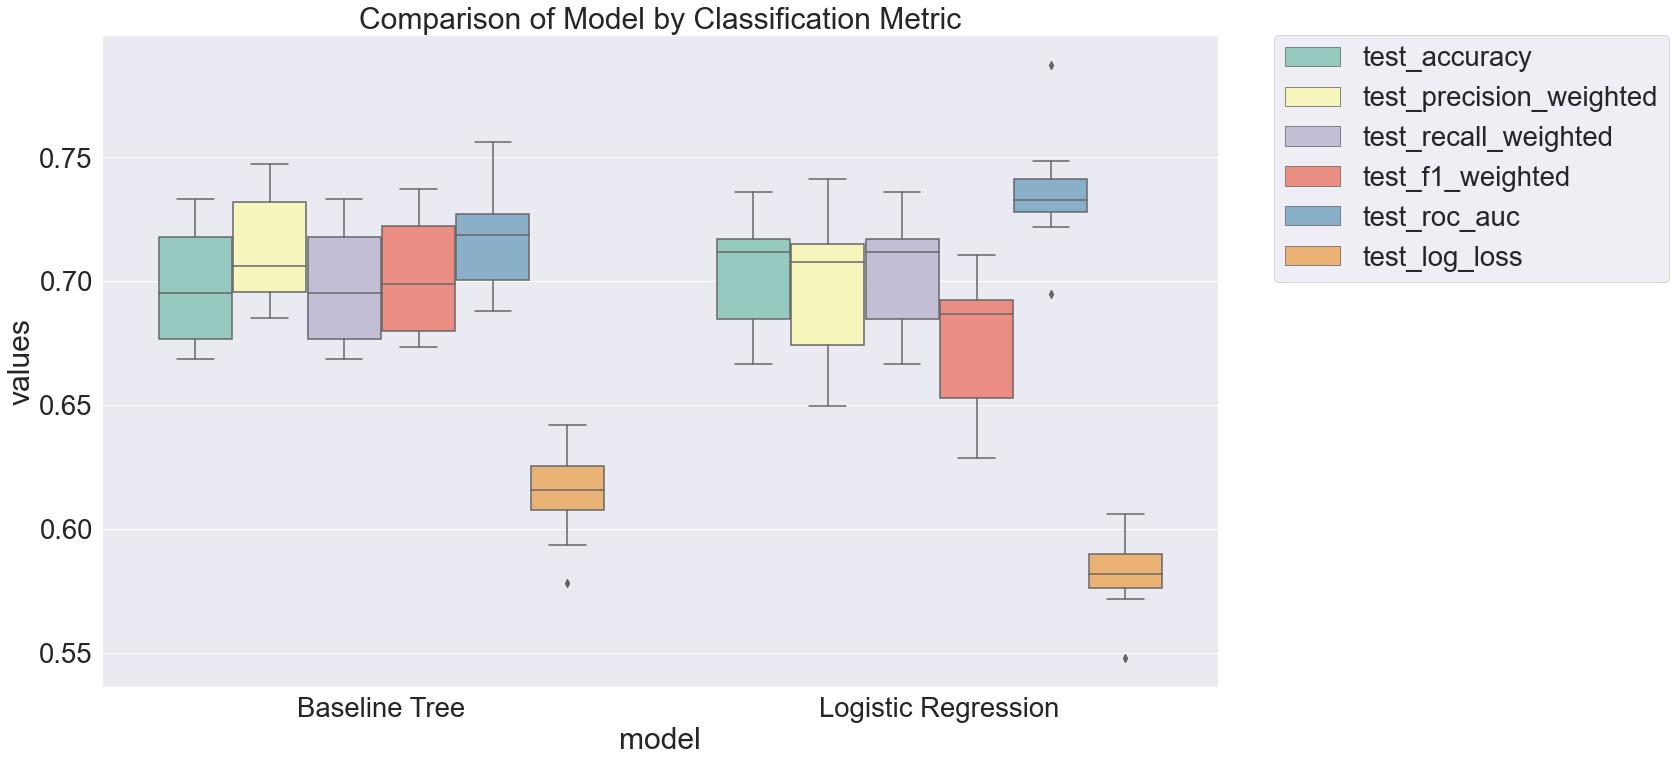

In [598]:
plt.figure(figsize=(20, 12))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=te5, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric');
#plt.savefig('./benchmark_models_performance.png',dpi=300)